In [ ]:
import tensorflow as tf
import os
tf.get_logger().setLevel('ERROR')
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Activation, Flatten
from tensorflow.keras.layers import LeakyReLU, ReLU, BatchNormalization, Dense, Input, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from collections import deque
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union
import copy
from enum import Enum
import time
from scipy.special import softmax



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
class Point2D:
  def __init__(self,x=0,y=0):
    self.x=x
    self.y=y


  def to_array(self):
    return [self.x,self.y]

  def to_int(self):
    return Point2D(int(self.x), int(self.y))

  def to_tuple(self):
    return (self.x, self.y)

  def __sub__(self, other):
    return Point2D(self.x - other.x, self.y - other.y)

  def __add__(self, other):
    return Point2D(self.x + other.x, self.y + other.y)

  def __mul__(self, other):
    return Point2D(self.x * other.x, self.y * other.y)

  def __truediv__(self, other):
    return Point2D(self.x / other.x, self.y / other.y)

  def add(self,x=0,y=0):
    return self + Point2D(x,y)

  def sub(self,x=0,y=0):
    return self.add(-x,-y)

  def mult(self,x=0,y=0):
    return Point2D(self.x*x, self.y*y)

  def div(self,x=0,y=0):
    return self / Point2D(x,y)

  def random(self,rect_limits):
    return Point2D(random.randint(rect_limits.start.x, rect_limits.end.x),
                   random.randint(rect_limits.start.y, rect_limits.end.y))

  def __str__(self):
    return "[{},{}]".format(self.x,self.y)

  def __eq__(self, other: 'Point2D'):
    return self.x == other.x and self.y == other.y

  def __hash__(self):
    return hash(("Point2D",self.x,self.y))



In [ ]:
class Rect2D():

  start : Point2D
  end : Point2D

  def __init__(self, start : Point2D, end : Point2D):


    self.start = start
    self.end = end
    self.x_size = self.end.x - self.start.x + 1
    self.y_size = self.end.y - self.start.y + 1
    self.size = self.x_size * self.y_size
    self.shape = (self.x_size, self.y_size)
    self.center = Point2D(x = int((start.x + end.x) / 2), y = int((start.y + end.y) / 2))

  def __getitem__(self, item: str):
    item = item.lower()
    if item == 'x1':
      return self.start.x
    elif item == 'x2':
      return self.end.x
    elif item == 'y1':
      return self.start.y
    elif item == 'y2':
      return self.end.y
    return None


  def __str__(self):
    return f"[{self.start} -> {self.end}]"

  def to_int(self):
    return Rect2D(self.start.to_int(), self.end.to_int())

  def __add__(self, other):
    def point(point: Point2D):
      return Rect2D(self.start + point, self.end + point)
    def rect(rect: 'Rect2D'):
      return Rect2D(self.start + rect.start, self.end + rect.end)

    map = {
      Point2D: point,
      Rect2D: rect
    }
    assert map.get(type(other)) != None
    return map[type(other)](other)


In [ ]:
class Statistics_plotter:

  def __init__(self):
    self.avg = lambda arr: sum(arr)/len(arr)
    self.max = lambda arr: max(arr)
    self.min = lambda arr: min(arr)
    
  def plot(self, data:Union[np.ndarray,list], *args:tuple, batch_size:int=1,
           xlabel:str="", ylabel:str="",title:str="",smooth:int = 0, weak_smooth=False, squish:int=None):
    '''Create a pyplot graph to be later shown'''
    if squish != None:
      data = self.__squish(data, squish)
    if smooth > 0:
      data = self.__smooth_data(data,smooth, weak_smooth)
    func_dir  = {"avg": self.avg, "max": self.max, "min": self.min}
    batch_array = []
    i = 0
    for _ in range(len(args)): batch_array.append([])

    while i < len(data):
      for j in range(len(args)):
        batch_array[j].append(func_dir.get(args[j][0])(data[i:i + batch_size]))
      i += batch_size

    for j in range(len(args)):
      plt.plot(range(1, len(batch_array[j]) + 1), batch_array[j], color=args[j][1], label=args[j][2])

    plt.legend(loc="upper left")
    if xlabel != "" :plt.xlabel(xlabel)
    if ylabel != "" :plt.ylabel(ylabel)
    if title != "" :plt.title(title)

    return self
  def show(self):
    '''Show pyplot graph'''
    plt.show()
    return self

  def xlabel(self, label:str):
    '''Set the x axis name of the pyplot graph'''
    plt.xlabel(label)
    return self

  def ylabel(self, label:str):
    '''Set the y axis name of the pyplot graph'''
    plt.ylabel(label)
    return self

  def title(self, title:str):
    '''Set the pyplot graph title'''
    plt.title(title)
    return self

  def __squish(self,data:Union[np.ndarray,list], max):
    '''squish the array values between 0 and 100
    
    data - The array to be squished
    max - The max value possible in the array
    '''
    if type(data) == list:
      data = np.array(data)
    return data * (100/max)

  def __smooth_data(self, data:Union[np.ndarray,list], smooth_power = 0, weak_smooth = False):
    data = np.array(data)
    smoothed_data = []
    for i in range(len(data)):
      max_left_smooth = min(smooth_power, i)
      max_right_smooth = min(smooth_power, len(data) - i - 1)
      smoothing_array = np.concatenate((np.linspace(1 / (max_left_smooth + 1), 1, num=max_left_smooth, endpoint=False), np.array([1]),
                      np.linspace(1 - (1 / (max_right_smooth + 1)), 0, num=max_right_smooth, endpoint=False)))
      if weak_smooth: smoothing_array *= smoothing_array
      smoothed_array = smoothing_array * data[i-max_left_smooth:i+max_right_smooth+1]
      smoothed_value = np.sum(smoothed_array) / np.sum(smoothing_array)
      smoothed_data.append(smoothed_value)
    return np.array(smoothed_data)




In [ ]:
def append_mat_with_offset(mat1, mat2, offset):
  '''add mat2 in a certain offset to mat1'''
  (pos_v, pos_h) = offset
  v_range1 = slice(max(0, pos_v), max(min(pos_v + mat2.shape[0], mat1.shape[0]), 0))
  h_range1 = slice(max(0, pos_h), max(min(pos_h + mat2.shape[1], mat1.shape[1]), 0))

  v_range2 = slice(max(0, -pos_v), min(-pos_v + mat1.shape[0], mat2.shape[0]))
  h_range2 = slice(max(0, -pos_h), min(-pos_h + mat1.shape[1], mat2.shape[1]))

  mat1[v_range1, h_range1] += mat2[v_range2, h_range2]

In [ ]:
class BlocksData(Enum):
  EMPTY = {'move_reward' : 0, 'mineable': False, 'mine_reward': 0},
  IRON = {'move_reward' : 0, 'mineable': True, 'mine_reward': 1},
  GOLD = {'move_reward' : 0, 'mineable': True, 'mine_reward': 3},
  DIAMONDS = {'move_reward' : 0, 'mineable': True, 'mine_reward': 10},
  LAVA = {'move_reward' : -5, 'mineable': True, 'mine_reward': -10},

class Blocks(Enum):
  EMPTY = 0
  IRON = 1
  GOLD = 3
  DIAMONDS = 10
  LAVA = -5

def block_data(index:Union[str,int]):
  '''Gets a "BlocksData" value using "Blocks" as a key'''
  if type(index) is int:
    return BlocksData[Blocks(index).name].value[0]
  elif type(index) is str:
    return BlocksData[index].value[0]

  raise Exception(f'incorrect type {type(index)}, expected str or int')

In [ ]:
class Logger():

  SAFETY_EPSILON = 1e-8

  def __init__(self, plotter):
    self.logger = {}
    self.epoch_logger = {}

    self.epoch_history = {
          'moved on iron' : [],
          'moved on gold' : [],
          'moved on diamonds' : [],
          'moved on lava' : [],
          'moved on empty' : [],
          'mined iron' : [],
          'mined gold' : [],
          'mined diamonds' : [],
          'mined lava' : [],
          'mined empty' : []}

  def __str__(self):
    return self.logger.__str__()

  def log_action(self, new_val, actions):
    '''Save an action and its consequences'''
    movement = Point2D(actions['move'][0], actions['move'][1]) 

    logger_key = ''
    curr_cell_value = new_val
    if movement != Point2D(0,0):
      logger_key += 'moved on '

    if actions['mine']:
      logger_key += 'mined '

    logger_key += Blocks(curr_cell_value).name.lower()
    logger_val = 1 if self.logger.get(logger_key) == None else self.logger.get(logger_key) + 1
    self.logger[logger_key] = logger_val

    epoch_logger_val = 1 if self.epoch_logger.get(logger_key) == None else self.epoch_logger.get(logger_key) + 1
    self.epoch_logger[logger_key] = epoch_logger_val

  def new_epoch(self):
    for key,value in self.epoch_history.items():
      epoch_val = Logger.SAFETY_EPSILON if self.epoch_logger.get(key) == None else self.epoch_logger.get(key)
      self.epoch_history[key].append(epoch_val)

    self.epoch_logger = {}
  def plot(self):
    '''Plot all graphs related to saved actions'''

    list_len = len(self.epoch_history.get('moved on empty'))
    batch_size = int(list_len/GRAPH_PLOT_FREQUENCY)
    smooth = int(list_len/40)
    squish = N_SIMULTANEOUS_GAMES * TURNS_IN_GAME #Used to show precentage instead of amount (if there are 200 turns total each epoch, value will be divided by 2)

    move_iron = np.array(self.epoch_history.get('moved on iron'),dtype=float)
    move_gold = np.array(self.epoch_history.get('moved on gold'),dtype=float)
    move_diamonds = np.array(self.epoch_history.get('moved on diamonds'),dtype=float)
    move_lava = np.array(self.epoch_history.get('moved on lava'),dtype=float)
    move_empty = np.array(self.epoch_history.get('moved on empty'),dtype=float)
    mine_iron = np.array(self.epoch_history.get('mined iron'),dtype=float)
    mine_gold = np.array(self.epoch_history.get('mined gold'),dtype=float)
    mine_diamonds = np.array(self.epoch_history.get('mined diamonds'),dtype=float)
    mine_lava = np.array(self.epoch_history.get('mined lava'),dtype=float)
    mine_empty = np.array(self.epoch_history.get('mined empty'),dtype=float)

    color_iron = ("avg","black",'iron')
    color_gold = ("avg","orange",'gold')
    color_diamonds = ("avg","cyan",'diamonds')
    color_lava = ("avg","red",'lava')
    color_empty = ("avg","grey",'empty')

    (
      plotter
      .plot(move_iron,color_iron,smooth=smooth, squish=squish)
      .plot(move_gold,color_gold,smooth=smooth, squish=squish)
      .plot(move_diamonds,color_diamonds,smooth=smooth, squish=squish)
      .plot(move_lava,color_lava,smooth=smooth, squish=squish)
      .title('Move action %')
      .show()
    )

    (
      plotter
      .plot(mine_iron,color_iron,smooth=smooth, squish=squish)
      .plot(mine_gold,color_gold,smooth=smooth, squish=squish)
      .plot(mine_diamonds,color_diamonds,smooth=smooth, squish=squish)
      .plot(mine_lava,color_lava,smooth=smooth, squish=squish)
      .title('Mine action %')
      .show()
    )

    precent_mine_iron = (mine_iron / move_iron) * 100
    precent_mine_gold = (mine_gold / move_gold) * 100
    precent_mine_diamonds = (mine_diamonds / move_diamonds) * 100
    precent_mine_lava = (mine_lava / move_lava) * 100
    precent_mine_empty = (mine_empty / move_empty) * 100

    (
      plotter
      .plot(precent_mine_iron,color_iron,smooth=smooth)
      .plot(precent_mine_gold,color_gold,smooth=smooth)
      .plot(precent_mine_diamonds,color_diamonds,smooth=smooth)
      .plot(precent_mine_lava,color_lava,smooth=smooth)
      .title('Mined encountered resources %')
      .show()
    )


    (
      plotter
      .plot((mine_iron / np.repeat(N_IRON*N_SIMULTANEOUS_GAMES,list_len)) * 100,color_iron,smooth=smooth)
      .plot((mine_gold / np.repeat(N_GOLD*N_SIMULTANEOUS_GAMES,list_len)) * 100,color_gold,smooth=smooth)
      .plot((mine_diamonds / np.repeat(N_DIAMONDS*N_SIMULTANEOUS_GAMES,list_len)) * 100,color_diamonds,smooth=smooth)
      .plot((mine_lava / np.repeat(N_LAVA*N_SIMULTANEOUS_GAMES,list_len)) * 100,color_lava,smooth=smooth)
      .title('Mined resources %')
      .show()
    )


In [ ]:
class Game():
  player_location: Point2D
  observation_rect: Rect2D

  def __init__(self, observation_rect: Rect2D, turns_in_game, reward_disperse_radius: int = 1, n_iron: int = 1,
               n_gold: int = 1, n_diamonds: int = 1, n_lava: int = 1):
    self.observation_rect = observation_rect
    self.reward_disperse_radius = reward_disperse_radius
    self.turns_in_game = turns_in_game

    self.map_width = int(observation_rect.x_size + turns_in_game * 2)
    self.map_height = int(observation_rect.y_size + turns_in_game * 2)
    self.center_on_map = Point2D(self.map_width / 2, self.map_height / 2).to_int()

    self.done = lambda: self.turn >= self.turns_in_game

    self.action_dict = {'move': np.array([0, 0]), 'mine': False}  # an empty move
    self.action_space = [
      {'move': np.array([1, 0]), 'mine': False},
      {'move': np.array([0, -1]), 'mine': False},
      {'move': np.array([-1, 0]), 'mine': False},
      {'move': np.array([0, 1]), 'mine': False},
      {'move': np.array([0, 0]), 'mine': True}]

    self.n_iron = n_iron
    self.n_gold = n_gold
    self.n_diamonds = n_diamonds
    self.n_lava = n_lava

  def mine(self):
    '''Mines the block underneath the player'''
    cell_on_map = self.map_values[int(self.player_location.x), int(self.player_location.y)]
    mine_value = block_data(int(cell_on_map))['mine_reward']
    player_location_int = self.player_location.to_int()

    # if a non empty block was mines, set it to an empty block
    if (cell_on_map != Blocks.EMPTY.value):
      self.map_values[player_location_int.x, player_location_int.y] = Blocks.EMPTY.value

    if self.map_values[int(self.player_location.x), int(self.player_location.y)] != self.map_values[player_location_int.x, player_location_int.y]:
      raise Exception
    if (int(self.player_location.x), int(self.player_location.y)) != (player_location_int.x, player_location_int.y):
      raise Exception
    return mine_value

  def reset(self):
    '''Reset games to initial state'''
    self.player_location = self.center_on_map
    self.turn = 0
    self.__init_map()

    return self.get_observation_grid()

  def do_actions(self, action_num, logger=None):
    '''Process and execute a player action'''
    actions = self.action_space[action_num]
    old_state = self.get_observation_grid()

    movement = Point2D(actions['move'][0], actions['move'][1])

    self.player_location = self.player_location + movement
    self.turn += 1

    curr_cell_value = self.map_values[int(self.player_location.x), int(self.player_location.y)]

    cell_data = block_data(int(curr_cell_value))

    if logger != None:
      logger.log_action(int(curr_cell_value), actions)

    mined_value = self.mine() if cell_data['mineable'] and actions['mine'] else cell_data['move_reward']

    return old_state, action_num, mined_value, self.get_observation_grid(), self.done()

  def get_observation_grid(self):
    '''Return the player visible surroundings'''
    player_observations = (self.observation_rect + self.player_location).to_int()
    observation_grid = self.map_values[player_observations.start.x:player_observations.end.x + 1,
                       player_observations.start.y:player_observations.end.y + 1]
    observation_grid = np.array(observation_grid)

    if (observation_grid.shape != (self.observation_rect.x_size, self.observation_rect.y_size)):
      raise Exception
    return observation_grid

  def __init_map(self):
    '''Populates the map with rewards'''
    reward_disperse_cells = self.reward_disperse_radius * 2 + 1
    reward_disperse_cells = reward_disperse_cells * reward_disperse_cells - 1
    n_rewards = self.n_iron + self.n_gold + self.n_diamonds + self.n_lava

    if reward_disperse_cells < n_rewards:
      print(f'empty cells for rewards are {reward_disperse_cells} but chosen {n_rewards} rewards')
      raise Exception

    self.map_values = np.zeros(self.map_width * self.map_height).reshape((self.map_width, self.map_height))

    rewards_in_radius = np.concatenate([np.repeat(Blocks.IRON.value, self.n_iron),
                                        np.repeat(Blocks.GOLD.value, self.n_gold),
                                        np.repeat(Blocks.DIAMONDS.value, self.n_diamonds),
                                        np.repeat(Blocks.LAVA.value, self.n_lava),
                                        np.repeat(Blocks.EMPTY.value,
                                                  reward_disperse_cells - n_rewards + 1)])  # +1 for the spawn point

    np.random.shuffle(rewards_in_radius)
    center = self.reward_disperse_radius * (self.reward_disperse_radius * 2 + 1) + self.reward_disperse_radius
    center_block = rewards_in_radius[center]

    while center_block != Blocks.EMPTY.value:
      np.random.shuffle(rewards_in_radius)
      center_block = rewards_in_radius[center]

    rewards_in_radius = rewards_in_radius.reshape(
      (self.reward_disperse_radius * 2 + 1, self.reward_disperse_radius * 2 + 1))
    append_offset = (
    self.center_on_map.x - self.reward_disperse_radius, self.center_on_map.y - self.reward_disperse_radius)

    append_mat_with_offset(self.map_values, rewards_in_radius, append_offset)




In [ ]:

class Agent:
  def __init__(self,
               gamma=0.3,
               epsilon=1,
               min_epsilon=0.1,
               epsilon_decay=0.9999,
               lr=5e-4,
               tau=0.125,
               replay_memory_size=1000000,
               min_replay_memory_size=200,
               minibatch_size=100,
               input_shape=None,
               output_size=5,
               target_train_frequency=5,
               enable_epsilon_decay=True,
               enable_random=True,
               enable_training=True,
               enable_probabilities=False):
    self.gamma = gamma
    self.min_epsilon = max(min(min_epsilon,1),0)
    self.epsilon = max(min(epsilon,1),self.min_epsilon)
    self.epsilon_decay = epsilon_decay
    self.lr = lr
    self.tau = tau
    self.replay_memory_size = replay_memory_size
    self.min_replay_memory_size = min_replay_memory_size
    self.minibatch_size = minibatch_size
    self.net_input_shape = input_shape
    self.net_output_size = output_size
    self.target_train_frequency = target_train_frequency
    self.enable_epsilon_decay = enable_epsilon_decay
    self.enable_random = enable_random
    self.enable_training = enable_training
    self.enable_probabilities = enable_probabilities
    # Main model
    self.model = self.create_model()

    # Target network
    self.target_model = self.create_model()
    self.target_model.set_weights(self.model.get_weights())

    # An array with last n steps for training
    self.memory = deque(maxlen=replay_memory_size)

    # Used to count when to update target network with main network's weights
    self.target_update_counter = 0

    self.checkpoint = tf.train.Checkpoint(model=self.model,
                                 target_model=self.target_model)

  def create_model(self):
    '''Craetes and returns a model'''
    model = Sequential()

    model.add(Flatten(input_shape=self.net_input_shape))
    model.add(Dense(1024, use_bias=False))
    model.add(ReLU())
    model.add(Dense(512, use_bias=False))
    model.add(ReLU())
    model.add(Dense(256, use_bias=False))
    model.add(ReLU())
    model.add(Dense(128, use_bias=False))
    model.add(ReLU())
    model.add(Dense(64, use_bias=False))
    model.add(ReLU())
    model.add(Dense(32, use_bias=False))
    model.add(ReLU())


    model.add(Dense(self.net_output_size))
    self.optimizer = Adam(lr=self.lr)
    model.compile(loss="mean_squared_error", optimizer=self.optimizer)
    print(model.summary())
    return model   

  def choose_action(self, state:np.ndarray):
    '''Predict and choose the best action given a single state'''
    return self.choose_action_multy(np.array([state]))[0]

  def choose_action_multy(self, states:np.ndarray):
    '''Predict and choose the best action given multiple states'''
    if self.enable_epsilon_decay:
      self.epsilon *= self.epsilon_decay
      self.epsilon = max(self.min_epsilon, self.epsilon)
    if self.enable_random and np.random.random() < self.epsilon:
      return np.random.randint(0,self.net_output_size -1, states.shape[0])
    actions = self.model.predict(states)
    if self.enable_probabilities:
      actions_probabilities = softmax(actions, axis=1) 
      chosen_actions = np.empty(actions_probabilities.shape[0],dtype=int)
      possible_actions = np.arange(self.net_output_size,dtype=int)
      for i in range(actions_probabilities.shape[0]):
        chosen_actions[i] = np.random.choice(self.net_output_size,1,p=actions_probabilities[i])[0]
    else:
      chosen_actions = np.argmax(actions,axis=1)
    return chosen_actions

  def predict(self, state):
    '''Predict action values given a single states'''
    return self.predict_multy(np.array([state]))[0]

  def predict_multy(self, states):
    '''Predict action values given multiple states'''
    return self.model.predict(states)

  def random_action(self):
    '''Choose a random action'''
    return random.randint(0,self.net_output_size-1)


  # Adds step's data to a memory replay array
  # (observation space, action, reward, new observation space, done)
  def remember(self, transitions:Union[np.ndarray,list]):
    '''Add multiple states to memory for later learning'''
    self.memory.extend(transitions)

  def replay(self):
    '''Learn using accumulated memory'''
    if self.enable_training:
      batch_size = self.minibatch_size
      if len(self.memory) < self.min_replay_memory_size:
        return

      samples = random.sample(self.memory, batch_size)
      states = np.array([sample[0] for sample in samples])
      targets = self.target_model.predict(states)
      new_states = np.array([sample[3] for sample in samples])
      target_qs = self.target_model.predict(new_states)

      for i,(_,action,reward,_,done) in enumerate(samples):
        target_q = target_qs[i]
        if done:
          targets[i][action] = reward
        else:
          Q_future = max(target_q)
          # targets[i]  = targets[i] - (np.abs(targets[i])/100)    #test
          targets[i][action] = reward + Q_future * self.gamma
      self.model.fit(states, targets, epochs=1, verbose=0)

  def target_train(self):
    '''Train target model to be a bit closer to the predicting model'''
    if self.enable_training:
      weights = self.model.get_weights()
      target_weights = self.target_model.get_weights()
      for i in range(len(target_weights)):
        target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
      self.target_model.set_weights(target_weights)


In [ ]:
#All global parameters

#Game
OBSERVATION_RADIUS = 3 #Defines the width and height of the square seen by the player
observation_metadata = Rect2D(Point2D(-OBSERVATION_RADIUS,-OBSERVATION_RADIUS),
                              Point2D(OBSERVATION_RADIUS,OBSERVATION_RADIUS)) # Rect that defines the bounds of the player sight
TURNS_IN_GAME = 70 # Number of moves the player can make before the game ends
REWARD_DISPERSE_RADIUS = 4 # The maximum distance from the starting point a reward can appear in
N_SIMULTANEOUS_GAMES = 64 # Number of games running simultaneousely (Game batch)

TIME_TRAIN_SECONDS = 11*3600 + 0*60 + 0*1
TIME_TEST_SECONDS = 1*3600 + 0*60 + 0*1

N_IRON = 8 # Number of iron blocks on the map
N_GOLD = 5 # Number of fold blocks on the map
N_DIAMONDS = 4 # Number of diamond blocks on the map
N_LAVA = 7 # Number of lava pits in the map

#Statistics
GRAPH_PLOT_FREQUENCY = 60           # Print graphs every X game batches
HISTORY_AVG_SIZE = 200               # Printed average will contain the average score of X last game batches
PROGRESS_FREQUENCY = 5              # Print progress every X game batches

#Checkpoints
ROOT_DIR = '/content/drive/My Drive/Deep Learning Finals/Checkpoints'
EXPERIMENT_NAME = '26_08_2020 smaller net probability no random'

SAVE_CHECKPOINTS = True
RESTORE_CHECKPOINT = True
SAVE_CHECKPOINT_FREQUENCY = 100

NET_INPUT_SHAPE = (observation_metadata.x_size , observation_metadata.y_size)


In [ ]:
agent = Agent(replay_memory_size=4000000,
              min_replay_memory_size=4000,
              minibatch_size=N_SIMULTANEOUS_GAMES,
              target_train_frequency=5,
              input_shape=NET_INPUT_SHAPE,
              output_size=5,
              gamma=0.95,
              epsilon=1,
              min_epsilon=0.1,
              epsilon_decay=math.pow(0.999998,N_SIMULTANEOUS_GAMES),
              lr=1.5e-6,
              tau=0.125,
              enable_probabilities=True)


score_history_train = []
score_history_test = []
plotter = Statistics_plotter()
games = []
train_logger = Logger(plotter)
test_logger = Logger(plotter)

for _ in range(N_SIMULTANEOUS_GAMES):
  games.append(Game(observation_metadata,
                    TURNS_IN_GAME,
                    reward_disperse_radius=REWARD_DISPERSE_RADIUS,
                    n_iron = N_IRON,
                    n_gold = N_GOLD,
                    n_diamonds = N_DIAMONDS,
                    n_lava = N_LAVA))
games = np.array(games)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524288    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131072    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0

In [ ]:
CHECKPOINTS_PROJ_DIR = os.path.join(ROOT_DIR,EXPERIMENT_NAME)

if SAVE_CHECKPOINTS or RESTORE_CHECKPOINT:
  from google.colab import drive
  drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def seconds_to_string(seconds): 

  seconds = int(seconds+0.5)
  seconds = seconds % (24 * 3600) 
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  return "%d:%02d:%02d" % (hour, minutes, seconds) 

In [ ]:
def print_progress(score_history, curr_time, start_time, fin_time, episode):
  avg_score = np.mean(score_history[-HISTORY_AVG_SIZE:])
  elapsed = seconds_to_string(curr_time-start_time)
  remaining = seconds_to_string(fin_time-curr_time)
  print(f'[{elapsed}]>[{remaining}] episode {episode}, avg score {avg_score}, epsilon {agent.epsilon}')

def plot_graphs(score_history, logger):
      (
      plotter.plot(score_history,("avg","blue","avg"),smooth=int(len(score_history)/40))
      .title('Rewards')
      .show()
      )
      logger.plot()

def run(score_history, logger, run_time):
  # for episode in tqdm(range(1, n_games + 1), ascii=True, unit=' episodes'):
  start_time = time.time()
  curr_time = start_time
  fin_time = curr_time + run_time
  episode = 1
  # for episode in range(1, n_games + 1):
  while curr_time < fin_time:
    # print(f"Start episode {episode}")
    curr_time = time.time()
    single_game(episode, logger, score_history)
    if episode % agent.target_train_frequency == 0:
      agent.target_train()
    if episode % PROGRESS_FREQUENCY == 0:
      print_progress(score_history, curr_time, start_time, fin_time, episode)
    if episode % GRAPH_PLOT_FREQUENCY == 0:
      plot_graphs(score_history, logger)
    episode += 1
  print("Run ended")
  print_progress(score_history, curr_time, start_time, fin_time, episode)
  plot_graphs(score_history, logger)

def run_train():
  '''Train the net using global training parameters'''
  score_history_train = []
  agent.enable_training=True
  return run(score_history_train, train_logger, TIME_TRAIN_SECONDS)

def run_test():
  '''Test the net using global testing parameters and disable net output randomization'''
  score_history_test = [] 
  prev_enable_epsilon_decay = agent.enable_epsilon_decay
  prev_enable_random = agent.enable_random
  # prev_enable_probabilities = agent.enable_probabilities
  # enable_probabilities=False
  agent.enable_epsilon_decay=False
  agent.enable_random=False
  agent.enable_training=False

  run_values = run(score_history_test, test_logger, TIME_TEST_SECONDS)

  agent.enable_epsilon_decay=prev_enable_epsilon_decay
  agent.enable_random=prev_enable_random
  # agent.enable_probabilities = prev_enable_probabilities

  return run_values


In [ ]:
def single_game(episode, logger, score_history):
  '''Run a single game batch'''
  done = False
  score = 0
  
  for game in games: game.reset()

  while not done:
    actions = []
    observations = []
    for i in range(N_SIMULTANEOUS_GAMES):
      observations.append(games[i].get_observation_grid().flatten())
    observations = np.array(observations)
    actions = agent.choose_action_multy(observations)


    actions = np.array(actions)
    sarsds = []
    rewards = []
    for i in range(N_SIMULTANEOUS_GAMES):
      state, action, reward, state_, done = games[i].do_actions(actions[i], logger=logger)
      sarsds.append((state.flatten(),action, reward, state_.flatten(), done))
      rewards.append(reward)
    agent.remember(sarsds)
    agent.replay()
    score +=  np.average(np.array(rewards))
  avg_score = np.mean(score_history[-HISTORY_AVG_SIZE:])
  if SAVE_CHECKPOINTS and episode % SAVE_CHECKPOINT_FREQUENCY == 0:
    save_checkpoint(agent, epoch=episode, avg=avg_score)
  score_history.append(score)
  logger.new_epoch()


In [ ]:
def restore_checkpoint(agent):
  '''Restores agents weights'''
  print(f"restoring from {CHECKPOINTS_PROJ_DIR}")
  observation = np.zeros((OBSERVATION_RADIUS*2+1) * (OBSERVATION_RADIUS*2+1)).reshape((OBSERVATION_RADIUS*2+1,OBSERVATION_RADIUS*2+1))
  prediction_before_restore = agent.predict(observation)
  agent.checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINTS_PROJ_DIR))
  prediction_after_restore = agent.predict(observation)
  if np.array_equal(prediction_before_restore, prediction_after_restore):
    print('Restore failed or current version is equal to restored version')
  else:
    print('Restore successful')

def save_checkpoint(agent,epoch=None, avg=None):
  '''Save agents weights'''
  agent.checkpoint.save(file_prefix = os.path.join(CHECKPOINTS_PROJ_DIR, checkpoint_file_prefix(epoch, avg)))

def checkpoint_file_prefix(epoch=None, avg=None):
  '''Create string prefix to saved checkpoints'''
  prefix = ""
  if epoch != None:
    prefix += f"epoch {epoch} "
  if avg != None:
    prefix += f"avg {avg} "
  return prefix

restoring from /content/drive/My Drive/Deep Learning Finals/Checkpoints/26_08_2020 smaller net probability no random
Restore failed or current version is equal to restored version


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0:00:40]>[10:59:20] episode 5, avg score -11.1, epsilon 0.95618865761454
[0:01:39]>[10:58:21] episode 10, avg score -11.346875, epsilon 0.9142967489506953
[0:02:40]>[10:57:20] episode 15, avg score -11.083333333333334, epsilon 0.8742401810405022
[0:03:39]>[10:56:21] episode 20, avg score -11.075, epsilon 0.8359385451418098
[0:04:38]>[10:55:22] episode 25, avg score -10.553125, epsilon 0.7993149553273973
[0:05:38]>[10:54:22] episode 30, avg score -10.330729166666666, epsilon 0.7642958941457301
[0:06:38]>[10:53:22] episode 35, avg score -9.720089285714286, epsilon 0.7308110650435105
[0:07:38]>[10:52:22] episode 40, avg score -9.358203125, epsilon 0.6987932512538071
[0:08:38]>[10:51:22] episode 45, avg score -8.930902777777778, epsilon 0.6681781808664771
[0:09:39]>[10:50:21] episode 50, avg score -8.481875, epsilon 0.6389043978100423
[0:10:39]>[10:49:21] episode 55, avg score -7.999147727272727, epsilon 0.6109131384860097
[0:11:39]>[10:48:21] episode 60, avg score -7.630989583333333, eps

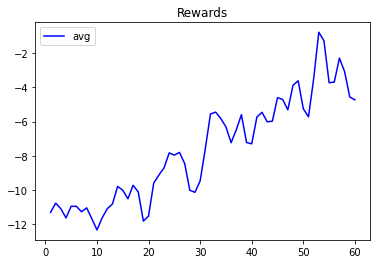

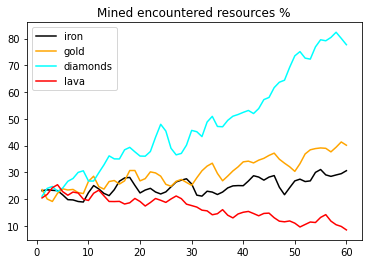

[0:12:42]>[10:47:18] episode 65, avg score -7.258894230769231, epsilon 0.5585558964090237
[0:13:43]>[10:46:17] episode 70, avg score -6.894642857142857, epsilon 0.5340848127900295
[0:14:43]>[10:45:17] episode 75, avg score -6.497708333333334, epsilon 0.5106858401940099
[0:15:44]>[10:44:16] episode 80, avg score -5.9974609375, epsilon 0.4883120079978622
[0:16:46]>[10:43:14] episode 85, avg score -5.558455882352941, epsilon 0.4669184034245357
[0:17:48]>[10:42:12] episode 90, avg score -5.1359375, epsilon 0.4464620813860306
[0:18:49]>[10:41:11] episode 95, avg score -4.703947368421052, epsilon 0.4269019782763016
[0:19:50]>[10:40:10] episode 100, avg score -4.261875, epsilon 0.408198829541008
[0:20:50]>[10:39:10] episode 105, avg score -3.8101190476190476, epsilon 0.39031509085864263
[0:21:51]>[10:38:09] episode 110, avg score -3.4553977272727274, epsilon 0.3732148627748228
[0:22:53]>[10:37:07] episode 115, avg score -3.0466032608695652, epsilon 0.35686381863845285
[0:23:54]>[10:36:06] epi

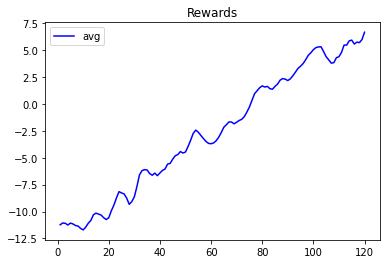

[0:24:56]>[10:35:04] episode 125, avg score -2.2445, epsilon 0.32627942919926883
[0:25:56]>[10:34:04] episode 130, avg score -1.8322115384615385, epsilon 0.3119846894132873
[0:26:58]>[10:33:02] episode 135, avg score -1.4289351851851853, epsilon 0.29831622136638014
[0:28:00]>[10:32:00] episode 140, avg score -1.0103794642857142, epsilon 0.28524658725296104
[0:29:01]>[10:30:59] episode 145, avg score -0.5626077586206897, epsilon 0.27274955135453705
[0:30:03]>[10:29:57] episode 150, avg score -0.19208333333333333, epsilon 0.2608000273746623
[0:31:05]>[10:28:55] episode 155, avg score 0.17237903225806453, epsilon 0.24937402808121312
[0:32:06]>[10:27:54] episode 160, avg score 0.58408203125, epsilon 0.23844861715490573
[0:33:08]>[10:26:52] episode 165, avg score 0.9085227272727273, epsilon 0.22800186314739262
[0:34:10]>[10:25:50] episode 170, avg score 1.256158088235294, epsilon 0.21801279545651928
[0:35:11]>[10:24:49] episode 175, avg score 1.619017857142857, epsilon 0.20846136223036227
[

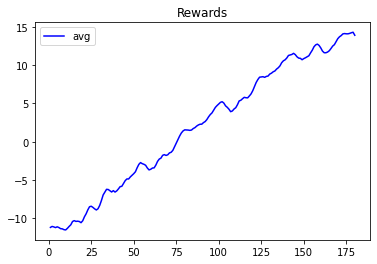

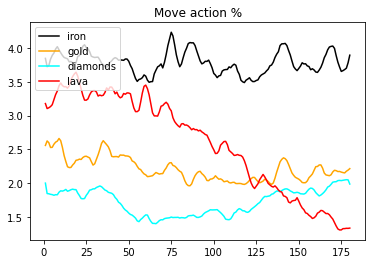

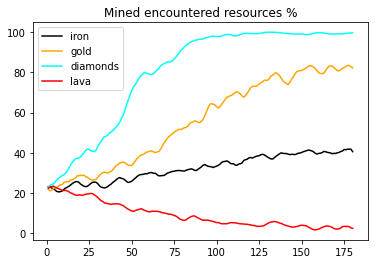

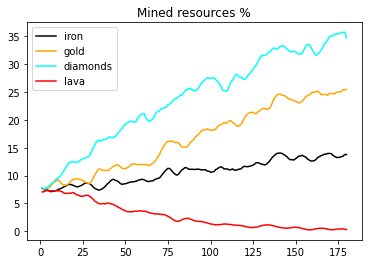

[0:37:15]>[10:22:45] episode 185, avg score 2.331672297297297, epsilon 0.19059554576905327
[0:38:18]>[10:21:42] episode 190, avg score 2.6881578947368423, epsilon 0.18224529905622147
[0:39:20]>[10:20:40] episode 195, avg score 3.0330929487179485, epsilon 0.17426088786112875
[0:40:22]>[10:19:38] episode 200, avg score 3.380859375, epsilon 0.16662628443865038
[0:41:25]>[10:18:35] episode 205, avg score 4.07390625, epsilon 0.15932616324069154
[0:42:27]>[10:17:33] episode 210, avg score 4.76625, epsilon 0.15234587015199172
[0:43:29]>[10:16:31] episode 215, avg score 5.489140625, epsilon 0.1456713930737517
[0:44:32]>[10:15:28] episode 220, avg score 6.22359375, epsilon 0.1392893337960303
[0:45:34]>[10:14:26] episode 225, avg score 6.920234375, epsilon 0.13318688110244986
[0:46:36]>[10:13:24] episode 230, avg score 7.623125, epsilon 0.12735178505321865
[0:47:38]>[10:12:22] episode 235, avg score 8.2459375, epsilon 0.12177233239485244
[0:48:41]>[10:11:19] episode 240, avg score 8.913984375, e

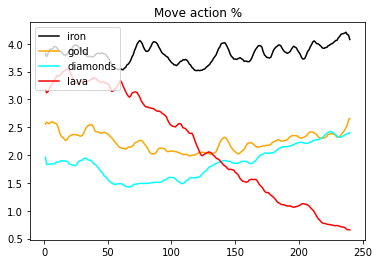

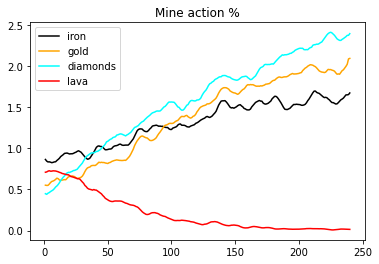

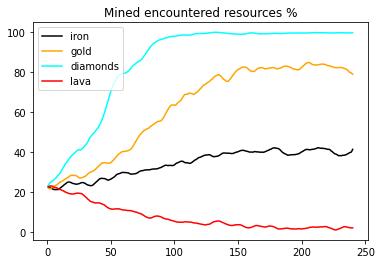

[0:49:45]>[10:10:15] episode 245, avg score 9.558828125, epsilon 0.11133604762075676
[0:50:47]>[10:09:13] episode 250, avg score 10.199453125, epsilon 0.10645826591859993
[0:51:50]>[10:08:10] episode 255, avg score 10.82265625, epsilon 0.10179418638067779
[0:52:52]>[10:07:08] episode 260, avg score 11.418359375, epsilon 0.1
[0:53:55]>[10:06:05] episode 265, avg score 12.015234375, epsilon 0.1
[0:54:58]>[10:05:02] episode 270, avg score 12.6228125, epsilon 0.1
[0:56:00]>[10:04:00] episode 275, avg score 13.198828125, epsilon 0.1
[0:57:02]>[10:02:58] episode 280, avg score 13.733671875, epsilon 0.1
[0:58:05]>[10:01:55] episode 285, avg score 14.285703125, epsilon 0.1
[0:59:09]>[10:00:51] episode 290, avg score 14.78453125, epsilon 0.1
[1:00:12]>[9:59:48] episode 295, avg score 15.307421875, epsilon 0.1
[1:01:15]>[9:58:45] episode 300, avg score 15.77078125, epsilon 0.1


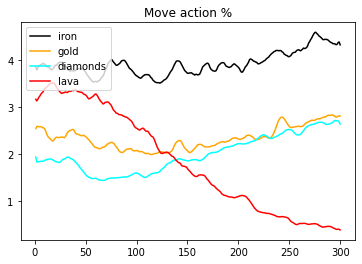

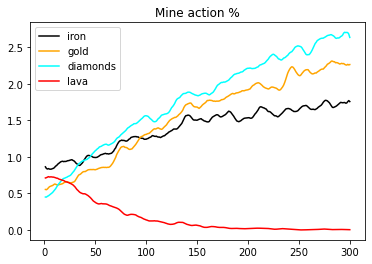

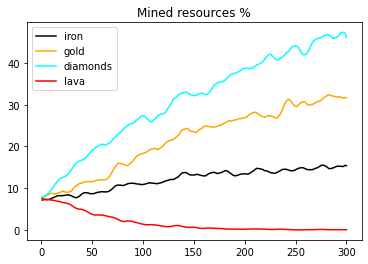

[1:02:19]>[9:57:41] episode 305, avg score 16.206640625, epsilon 0.1
[1:03:22]>[9:56:38] episode 310, avg score 16.732890625, epsilon 0.1
[1:04:26]>[9:55:34] episode 315, avg score 17.16875, epsilon 0.1
[1:05:29]>[9:54:31] episode 320, avg score 17.6328125, epsilon 0.1
[1:06:32]>[9:53:28] episode 325, avg score 18.04953125, epsilon 0.1
[1:07:36]>[9:52:24] episode 330, avg score 18.445546875, epsilon 0.1
[1:08:40]>[9:51:20] episode 335, avg score 18.859296875, epsilon 0.1
[1:09:44]>[9:50:16] episode 340, avg score 19.241953125, epsilon 0.1
[1:10:47]>[9:49:13] episode 345, avg score 19.580078125, epsilon 0.1
[1:11:50]>[9:48:10] episode 350, avg score 19.94234375, epsilon 0.1
[1:12:52]>[9:47:08] episode 355, avg score 20.32296875, epsilon 0.1
[1:13:56]>[9:46:04] episode 360, avg score 20.6265625, epsilon 0.1


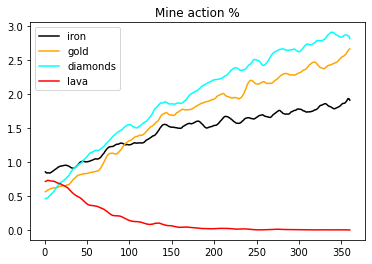

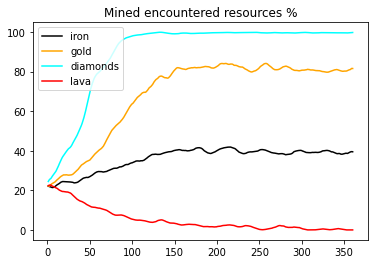

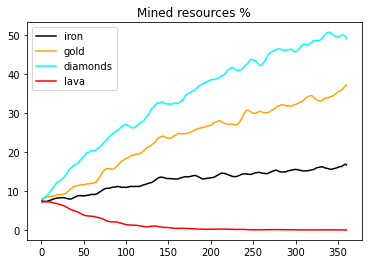

[1:15:02]>[9:44:58] episode 365, avg score 21.0059375, epsilon 0.1
[1:16:06]>[9:43:54] episode 370, avg score 21.33515625, epsilon 0.1
[1:17:09]>[9:42:51] episode 375, avg score 21.6403125, epsilon 0.1
[1:18:14]>[9:41:46] episode 380, avg score 22.00765625, epsilon 0.1
[1:19:19]>[9:40:41] episode 385, avg score 22.318359375, epsilon 0.1
[1:20:25]>[9:39:35] episode 390, avg score 22.602109375, epsilon 0.1
[1:21:30]>[9:38:30] episode 395, avg score 22.903125, epsilon 0.1
[1:22:34]>[9:37:26] episode 400, avg score 23.149765625, epsilon 0.1
[1:23:39]>[9:36:21] episode 405, avg score 23.444921875, epsilon 0.1
[1:24:43]>[9:35:17] episode 410, avg score 23.774921875, epsilon 0.1
[1:25:49]>[9:34:11] episode 415, avg score 24.006171875, epsilon 0.1
[1:26:55]>[9:33:05] episode 420, avg score 24.2725, epsilon 0.1


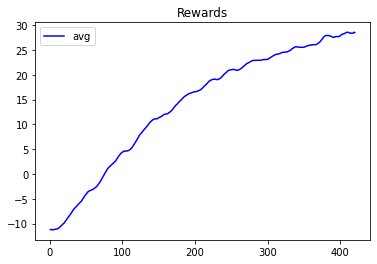

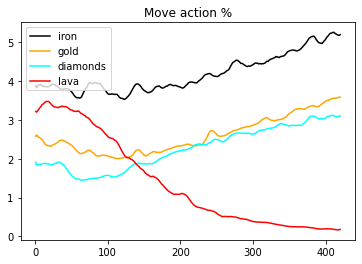

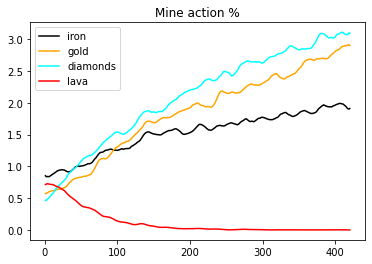

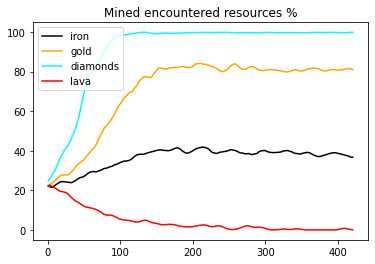

[1:28:01]>[9:31:59] episode 425, avg score 24.50453125, epsilon 0.1
[1:29:06]>[9:30:54] episode 430, avg score 24.7475, epsilon 0.1
[1:30:11]>[9:29:49] episode 435, avg score 25.01515625, epsilon 0.1
[1:31:16]>[9:28:44] episode 440, avg score 25.27796875, epsilon 0.1
[1:32:20]>[9:27:40] episode 445, avg score 25.498515625, epsilon 0.1
[1:33:24]>[9:26:36] episode 450, avg score 25.69015625, epsilon 0.1
[1:34:28]>[9:25:32] episode 455, avg score 25.903671875, epsilon 0.1
[1:35:32]>[9:24:28] episode 460, avg score 26.117734375, epsilon 0.1
[1:36:36]>[9:23:24] episode 465, avg score 26.373125, epsilon 0.1
[1:37:40]>[9:22:20] episode 470, avg score 26.588359375, epsilon 0.1
[1:38:44]>[9:21:16] episode 475, avg score 26.801796875, epsilon 0.1
[1:39:49]>[9:20:11] episode 480, avg score 27.00046875, epsilon 0.1


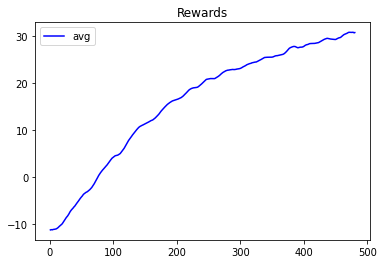

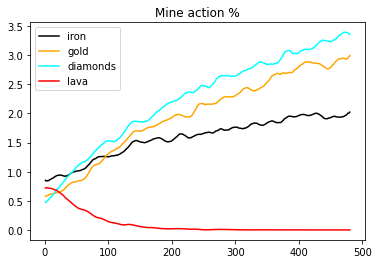

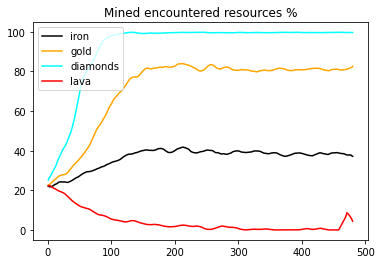

[1:40:55]>[9:19:05] episode 485, avg score 27.2, epsilon 0.1
[1:42:00]>[9:18:00] episode 490, avg score 27.43203125, epsilon 0.1
[1:43:04]>[9:16:56] episode 495, avg score 27.6175, epsilon 0.1
[1:44:09]>[9:15:51] episode 500, avg score 27.834453125, epsilon 0.1
[1:45:14]>[9:14:46] episode 505, avg score 28.045078125, epsilon 0.1
[1:46:19]>[9:13:41] episode 510, avg score 28.225625, epsilon 0.1
[1:47:24]>[9:12:36] episode 515, avg score 28.438984375, epsilon 0.1
[1:48:29]>[9:11:31] episode 520, avg score 28.64359375, epsilon 0.1
[1:49:34]>[9:10:26] episode 525, avg score 28.804609375, epsilon 0.1
[1:50:39]>[9:09:21] episode 530, avg score 28.969765625, epsilon 0.1
[1:51:44]>[9:08:16] episode 535, avg score 29.146640625, epsilon 0.1
[1:52:50]>[9:07:10] episode 540, avg score 29.273359375, epsilon 0.1


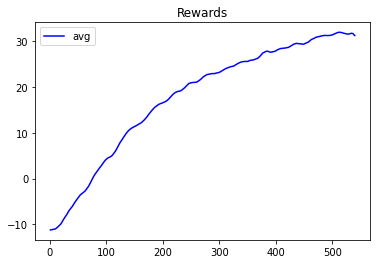

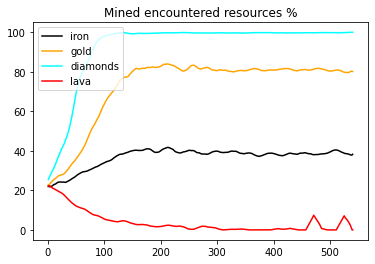

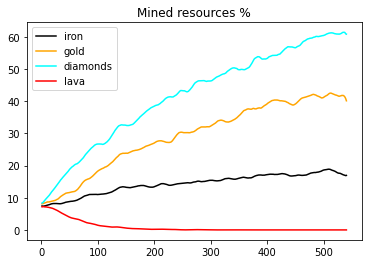

[1:53:56]>[9:06:04] episode 545, avg score 29.422890625, epsilon 0.1
[1:55:01]>[9:04:59] episode 550, avg score 29.598203125, epsilon 0.1
[1:56:07]>[9:03:53] episode 555, avg score 29.751328125, epsilon 0.1
[1:57:13]>[9:02:47] episode 560, avg score 29.9078125, epsilon 0.1
[1:58:18]>[9:01:42] episode 565, avg score 30.06921875, epsilon 0.1
[1:59:24]>[9:00:36] episode 570, avg score 30.23671875, epsilon 0.1
[2:00:31]>[8:59:29] episode 575, avg score 30.42765625, epsilon 0.1
[2:01:38]>[8:58:22] episode 580, avg score 30.547109375, epsilon 0.1
[2:02:44]>[8:57:16] episode 585, avg score 30.66515625, epsilon 0.1
[2:03:51]>[8:56:09] episode 590, avg score 30.831484375, epsilon 0.1
[2:04:57]>[8:55:03] episode 595, avg score 30.945, epsilon 0.1
[2:06:04]>[8:53:56] episode 600, avg score 31.118671875, epsilon 0.1


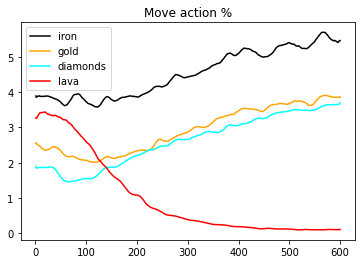

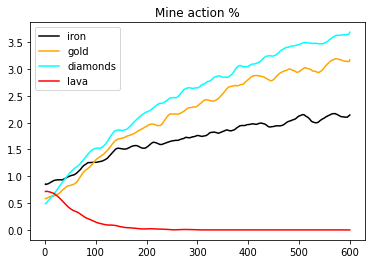

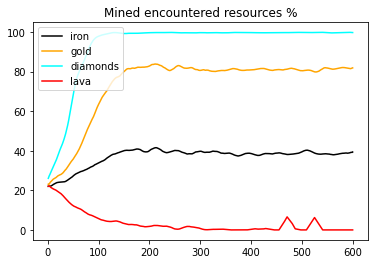

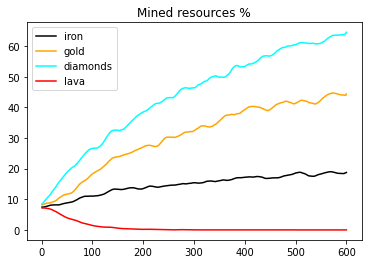

[2:07:15]>[8:52:45] episode 605, avg score 31.26421875, epsilon 0.1
[2:08:23]>[8:51:37] episode 610, avg score 31.35890625, epsilon 0.1
[2:09:30]>[8:50:30] episode 615, avg score 31.523515625, epsilon 0.1
[2:10:37]>[8:49:23] episode 620, avg score 31.65453125, epsilon 0.1
[2:11:45]>[8:48:15] episode 625, avg score 31.7903125, epsilon 0.1
[2:12:53]>[8:47:07] episode 630, avg score 31.92578125, epsilon 0.1
[2:13:59]>[8:46:01] episode 635, avg score 32.04390625, epsilon 0.1
[2:15:07]>[8:44:53] episode 640, avg score 32.166484375, epsilon 0.1
[2:16:15]>[8:43:45] episode 645, avg score 32.332890625, epsilon 0.1
[2:17:23]>[8:42:37] episode 650, avg score 32.530234375, epsilon 0.1
[2:18:30]>[8:41:30] episode 655, avg score 32.65921875, epsilon 0.1
[2:19:36]>[8:40:24] episode 660, avg score 32.790625, epsilon 0.1


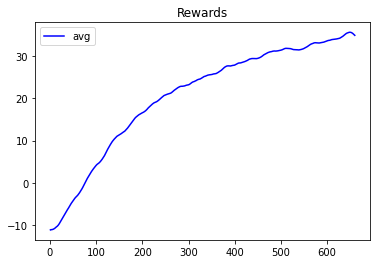

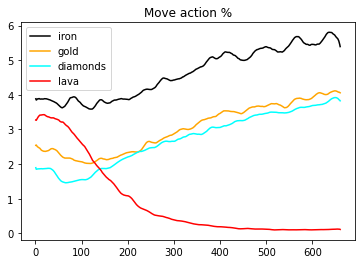

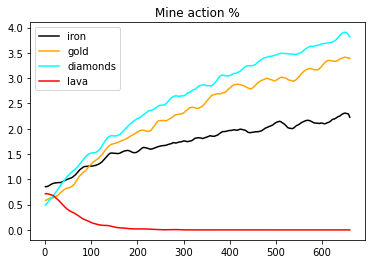

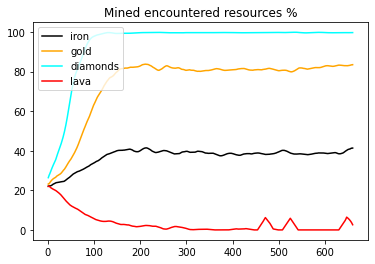

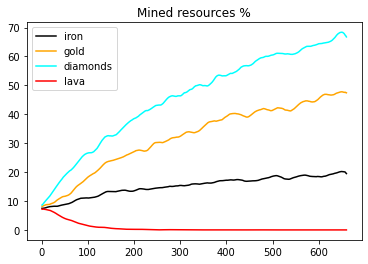

[2:20:45]>[8:39:15] episode 665, avg score 32.86, epsilon 0.1
[2:21:52]>[8:38:08] episode 670, avg score 32.976328125, epsilon 0.1
[2:22:59]>[8:37:01] episode 675, avg score 33.096484375, epsilon 0.1
[2:24:06]>[8:35:54] episode 680, avg score 33.1846875, epsilon 0.1
[2:25:14]>[8:34:46] episode 685, avg score 33.23828125, epsilon 0.1
[2:26:20]>[8:33:40] episode 690, avg score 33.330546875, epsilon 0.1
[2:27:29]>[8:32:31] episode 695, avg score 33.4434375, epsilon 0.1
[2:28:37]>[8:31:23] episode 700, avg score 33.57265625, epsilon 0.1
[2:29:45]>[8:30:15] episode 705, avg score 33.685859375, epsilon 0.1
[2:30:53]>[8:29:07] episode 710, avg score 33.77375, epsilon 0.1
[2:32:01]>[8:27:59] episode 715, avg score 33.874140625, epsilon 0.1
[2:33:09]>[8:26:51] episode 720, avg score 33.963828125, epsilon 0.1


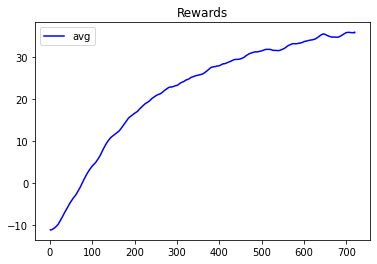

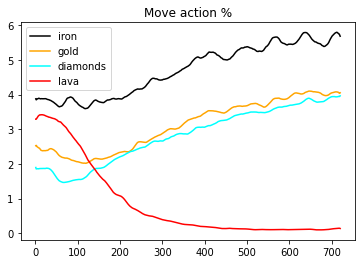

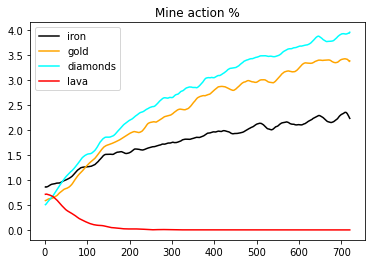

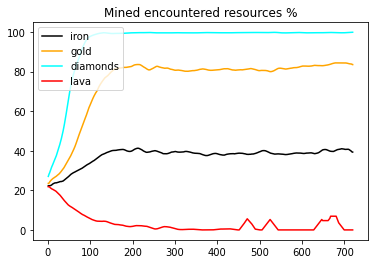

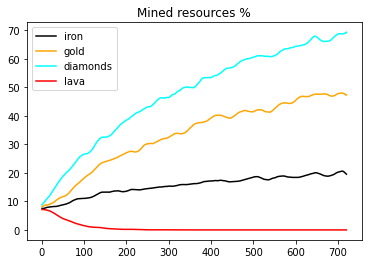

[2:34:20]>[8:25:40] episode 725, avg score 34.101796875, epsilon 0.1
[2:35:30]>[8:24:30] episode 730, avg score 34.241015625, epsilon 0.1
[2:36:39]>[8:23:21] episode 735, avg score 34.319375, epsilon 0.1
[2:37:48]>[8:22:12] episode 740, avg score 34.467578125, epsilon 0.1
[2:38:57]>[8:21:03] episode 745, avg score 34.576796875, epsilon 0.1
[2:40:06]>[8:19:54] episode 750, avg score 34.6859375, epsilon 0.1
[2:41:14]>[8:18:46] episode 755, avg score 34.7696875, epsilon 0.1
[2:42:21]>[8:17:39] episode 760, avg score 34.880234375, epsilon 0.1
[2:43:29]>[8:16:31] episode 765, avg score 34.9703125, epsilon 0.1
[2:44:37]>[8:15:23] episode 770, avg score 35.05140625, epsilon 0.1
[2:45:46]>[8:14:14] episode 775, avg score 35.157890625, epsilon 0.1
[2:46:56]>[8:13:04] episode 780, avg score 35.25578125, epsilon 0.1


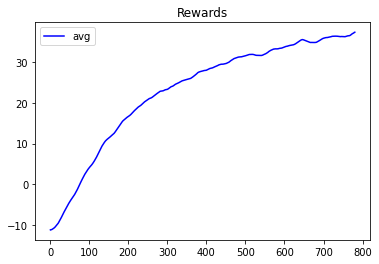

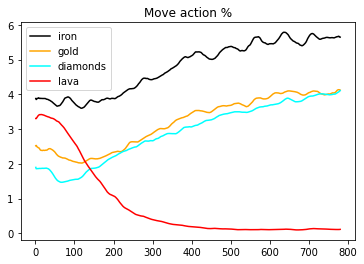

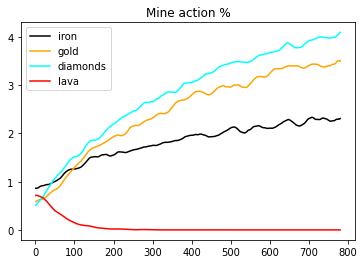

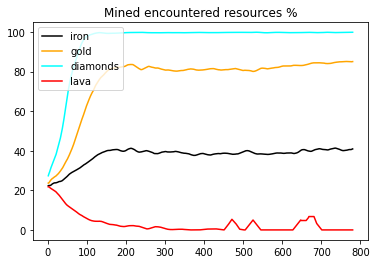

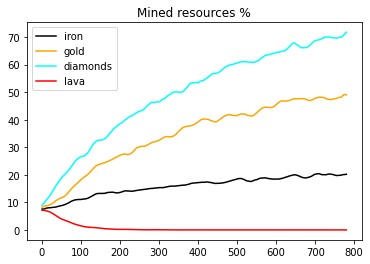

[2:48:07]>[8:11:53] episode 785, avg score 35.368359375, epsilon 0.1
[2:49:15]>[8:10:45] episode 790, avg score 35.41515625, epsilon 0.1
[2:50:23]>[8:09:37] episode 795, avg score 35.499765625, epsilon 0.1
[2:51:32]>[8:08:28] episode 800, avg score 35.601484375, epsilon 0.1
[2:52:41]>[8:07:19] episode 805, avg score 35.676171875, epsilon 0.1
[2:53:50]>[8:06:10] episode 810, avg score 35.783828125, epsilon 0.1
[2:54:59]>[8:05:01] episode 815, avg score 35.860625, epsilon 0.1
[2:56:08]>[8:03:52] episode 820, avg score 35.950859375, epsilon 0.1
[2:57:18]>[8:02:42] episode 825, avg score 36.040703125, epsilon 0.1
[2:58:29]>[8:01:31] episode 830, avg score 36.152578125, epsilon 0.1
[2:59:38]>[8:00:22] episode 835, avg score 36.24828125, epsilon 0.1
[3:00:48]>[7:59:12] episode 840, avg score 36.3225, epsilon 0.1


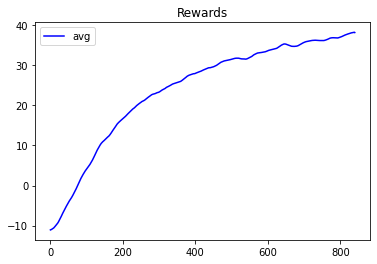

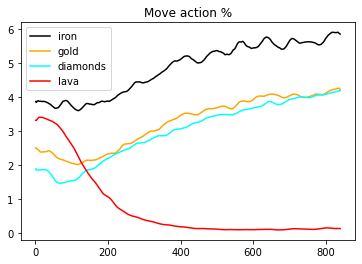

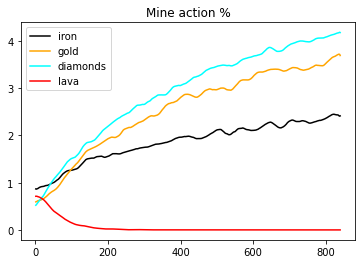

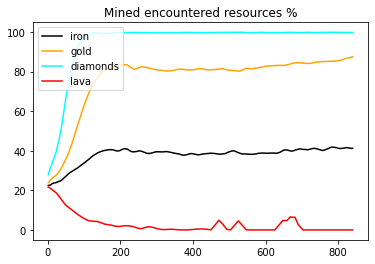

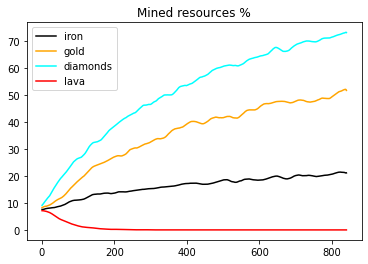

[3:01:58]>[7:58:02] episode 845, avg score 36.38390625, epsilon 0.1
[3:03:07]>[7:56:53] episode 850, avg score 36.4078125, epsilon 0.1
[3:04:17]>[7:55:43] episode 855, avg score 36.47078125, epsilon 0.1
[3:05:27]>[7:54:33] episode 860, avg score 36.5534375, epsilon 0.1
[3:06:36]>[7:53:24] episode 865, avg score 36.65140625, epsilon 0.1
[3:07:45]>[7:52:15] episode 870, avg score 36.698984375, epsilon 0.1
[3:08:55]>[7:51:05] episode 875, avg score 36.793828125, epsilon 0.1
[3:10:05]>[7:49:55] episode 880, avg score 36.87625, epsilon 0.1
[3:11:15]>[7:48:45] episode 885, avg score 36.9840625, epsilon 0.1
[3:12:25]>[7:47:35] episode 890, avg score 37.047890625, epsilon 0.1
[3:13:35]>[7:46:25] episode 895, avg score 37.148046875, epsilon 0.1
[3:14:45]>[7:45:15] episode 900, avg score 37.19703125, epsilon 0.1


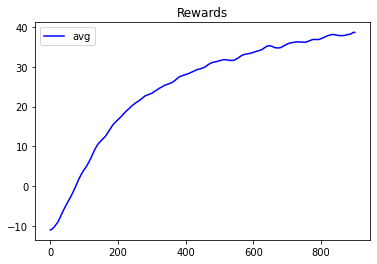

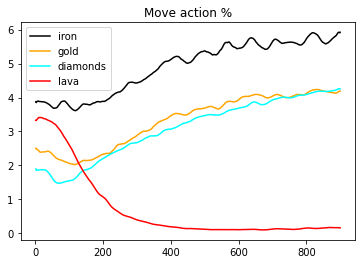

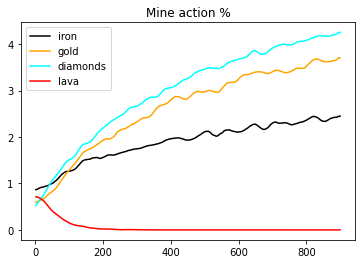

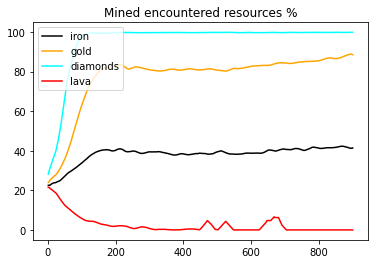

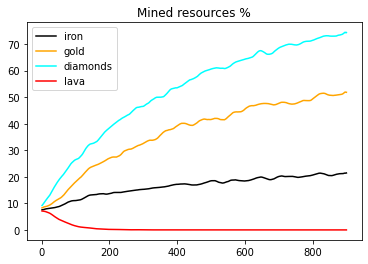

[3:15:58]>[7:44:02] episode 905, avg score 37.27578125, epsilon 0.1
[3:17:08]>[7:42:52] episode 910, avg score 37.37078125, epsilon 0.1
[3:18:19]>[7:41:41] episode 915, avg score 37.409921875, epsilon 0.1
[3:19:29]>[7:40:31] episode 920, avg score 37.47, epsilon 0.1
[3:20:39]>[7:39:21] episode 925, avg score 37.54640625, epsilon 0.1
[3:21:49]>[7:38:11] episode 930, avg score 37.62375, epsilon 0.1
[3:22:59]>[7:37:01] episode 935, avg score 37.70703125, epsilon 0.1
[3:24:09]>[7:35:51] episode 940, avg score 37.760546875, epsilon 0.1
[3:25:19]>[7:34:41] episode 945, avg score 37.86421875, epsilon 0.1
[3:26:29]>[7:33:31] episode 950, avg score 37.938125, epsilon 0.1
[3:27:39]>[7:32:21] episode 955, avg score 38.0278125, epsilon 0.1
[3:28:50]>[7:31:10] episode 960, avg score 38.106796875, epsilon 0.1


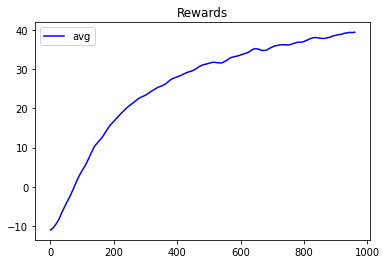

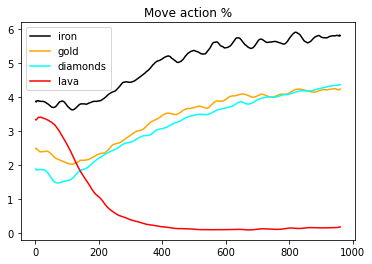

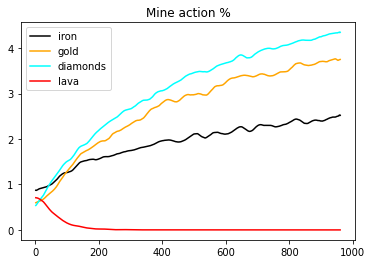

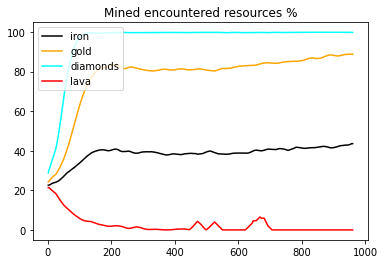

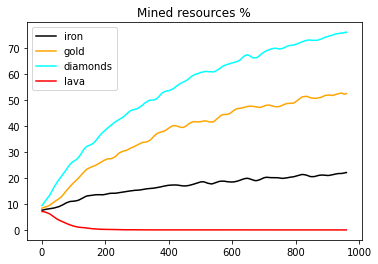

[3:30:03]>[7:29:57] episode 965, avg score 38.192890625, epsilon 0.1
[3:31:13]>[7:28:47] episode 970, avg score 38.280546875, epsilon 0.1
[3:32:23]>[7:27:37] episode 975, avg score 38.324140625, epsilon 0.1
[3:33:34]>[7:26:26] episode 980, avg score 38.365234375, epsilon 0.1
[3:34:44]>[7:25:16] episode 985, avg score 38.416640625, epsilon 0.1
[3:35:54]>[7:24:06] episode 990, avg score 38.48265625, epsilon 0.1
[3:37:04]>[7:22:56] episode 995, avg score 38.57453125, epsilon 0.1
[3:38:14]>[7:21:46] episode 1000, avg score 38.62625, epsilon 0.1
[3:39:25]>[7:20:35] episode 1005, avg score 38.7025, epsilon 0.1
[3:40:35]>[7:19:25] episode 1010, avg score 38.765078125, epsilon 0.1
[3:41:46]>[7:18:14] episode 1015, avg score 38.85875, epsilon 0.1
[3:42:56]>[7:17:04] episode 1020, avg score 38.936953125, epsilon 0.1


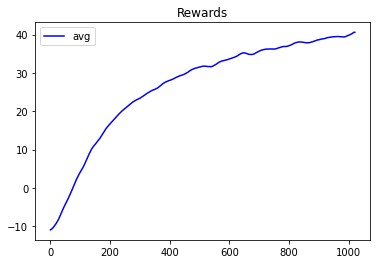

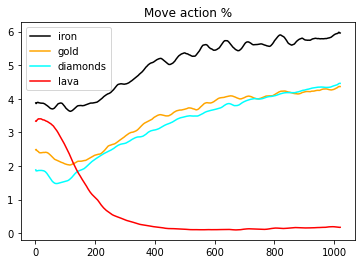

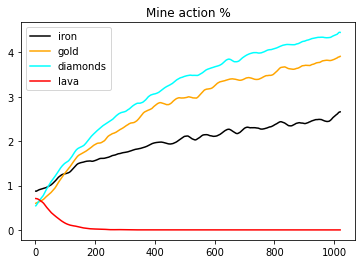

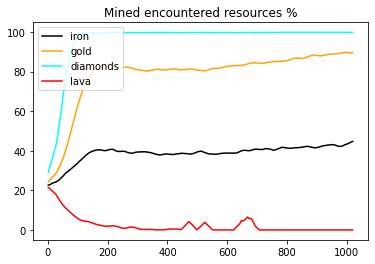

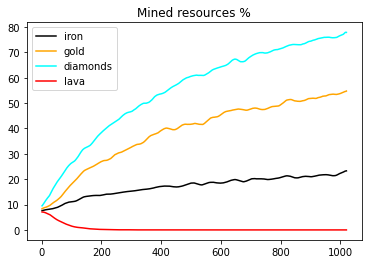

[3:44:08]>[7:15:52] episode 1025, avg score 38.992421875, epsilon 0.1
[3:45:20]>[7:14:40] episode 1030, avg score 39.05171875, epsilon 0.1
[3:46:30]>[7:13:30] episode 1035, avg score 39.098828125, epsilon 0.1
[3:47:40]>[7:12:20] episode 1040, avg score 39.145390625, epsilon 0.1
[3:48:50]>[7:11:10] episode 1045, avg score 39.185234375, epsilon 0.1
[3:50:00]>[7:10:00] episode 1050, avg score 39.2675, epsilon 0.1
[3:51:11]>[7:08:49] episode 1055, avg score 39.307421875, epsilon 0.1
[3:52:22]>[7:07:38] episode 1060, avg score 39.387421875, epsilon 0.1
[3:53:32]>[7:06:28] episode 1065, avg score 39.48109375, epsilon 0.1
[3:54:44]>[7:05:16] episode 1070, avg score 39.579765625, epsilon 0.1
[3:55:57]>[7:04:03] episode 1075, avg score 39.61671875, epsilon 0.1
[3:57:09]>[7:02:51] episode 1080, avg score 39.705, epsilon 0.1


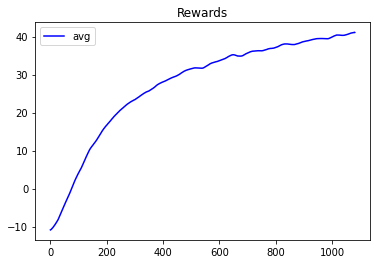

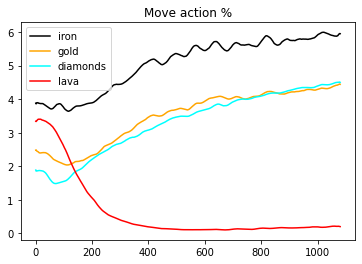

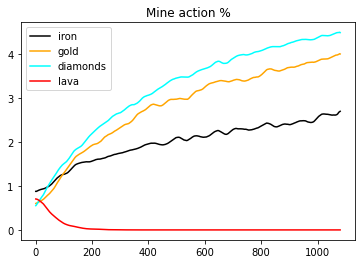

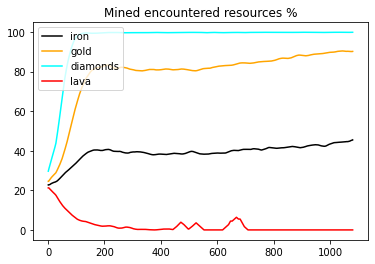

[3:58:24]>[7:01:36] episode 1085, avg score 39.76328125, epsilon 0.1
[3:59:36]>[7:00:24] episode 1090, avg score 39.880703125, epsilon 0.1
[4:00:48]>[6:59:12] episode 1095, avg score 39.92875, epsilon 0.1
[4:01:59]>[6:58:01] episode 1100, avg score 40.00734375, epsilon 0.1
[4:03:10]>[6:56:50] episode 1105, avg score 40.065703125, epsilon 0.1
[4:04:21]>[6:55:39] episode 1110, avg score 40.125625, epsilon 0.1
[4:05:32]>[6:54:28] episode 1115, avg score 40.21, epsilon 0.1
[4:06:44]>[6:53:16] episode 1120, avg score 40.273671875, epsilon 0.1
[4:07:56]>[6:52:04] episode 1125, avg score 40.33171875, epsilon 0.1
[4:09:08]>[6:50:52] episode 1130, avg score 40.39890625, epsilon 0.1
[4:10:20]>[6:49:40] episode 1135, avg score 40.480625, epsilon 0.1
[4:11:32]>[6:48:28] episode 1140, avg score 40.566484375, epsilon 0.1


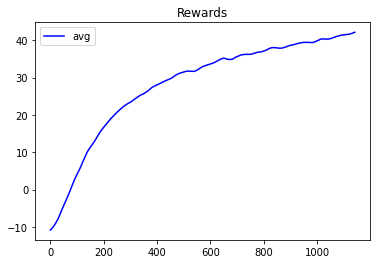

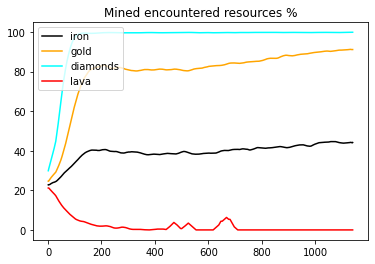

[4:12:47]>[6:47:13] episode 1145, avg score 40.59484375, epsilon 0.1
[4:13:59]>[6:46:01] episode 1150, avg score 40.647734375, epsilon 0.1
[4:15:10]>[6:44:50] episode 1155, avg score 40.697265625, epsilon 0.1
[4:16:23]>[6:43:37] episode 1160, avg score 40.782578125, epsilon 0.1
[4:17:35]>[6:42:25] episode 1165, avg score 40.85890625, epsilon 0.1
[4:18:47]>[6:41:13] episode 1170, avg score 40.94390625, epsilon 0.1
[4:19:59]>[6:40:01] episode 1175, avg score 41.017421875, epsilon 0.1
[4:21:11]>[6:38:49] episode 1180, avg score 41.11703125, epsilon 0.1
[4:22:24]>[6:37:36] episode 1185, avg score 41.179375, epsilon 0.1
[4:23:36]>[6:36:24] episode 1190, avg score 41.281640625, epsilon 0.1
[4:24:48]>[6:35:12] episode 1195, avg score 41.323046875, epsilon 0.1
[4:25:59]>[6:34:01] episode 1200, avg score 41.39234375, epsilon 0.1


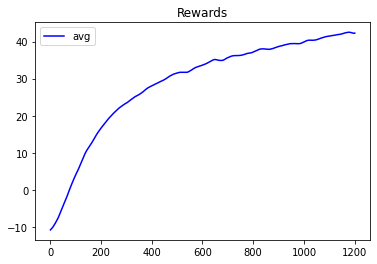

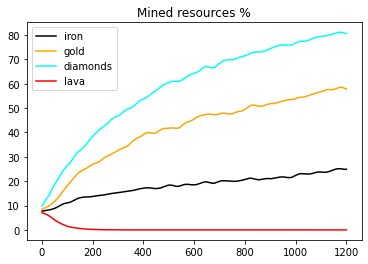

[4:27:14]>[6:32:46] episode 1205, avg score 41.46203125, epsilon 0.1
[4:28:25]>[6:31:35] episode 1210, avg score 41.536875, epsilon 0.1
[4:29:36]>[6:30:24] episode 1215, avg score 41.578984375, epsilon 0.1
[4:30:48]>[6:29:12] episode 1220, avg score 41.643125, epsilon 0.1
[4:31:59]>[6:28:01] episode 1225, avg score 41.7503125, epsilon 0.1
[4:33:10]>[6:26:50] episode 1230, avg score 41.821875, epsilon 0.1
[4:34:21]>[6:25:39] episode 1235, avg score 41.882109375, epsilon 0.1
[4:35:31]>[6:24:29] episode 1240, avg score 41.9709375, epsilon 0.1
[4:36:42]>[6:23:18] episode 1245, avg score 42.066875, epsilon 0.1
[4:37:53]>[6:22:07] episode 1250, avg score 42.165703125, epsilon 0.1
[4:39:04]>[6:20:56] episode 1255, avg score 42.27265625, epsilon 0.1
[4:40:16]>[6:19:44] episode 1260, avg score 42.38203125, epsilon 0.1


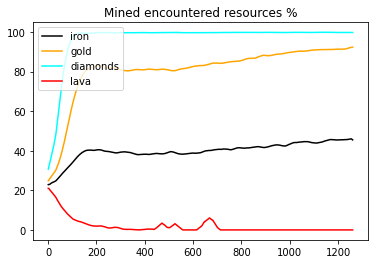

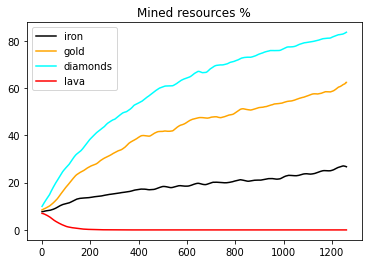

[4:41:30]>[6:18:30] episode 1265, avg score 42.459765625, epsilon 0.1
[4:42:41]>[6:17:19] episode 1270, avg score 42.528828125, epsilon 0.1
[4:43:52]>[6:16:08] episode 1275, avg score 42.6071875, epsilon 0.1
[4:45:03]>[6:14:57] episode 1280, avg score 42.689765625, epsilon 0.1
[4:46:14]>[6:13:46] episode 1285, avg score 42.77953125, epsilon 0.1
[4:47:26]>[6:12:34] episode 1290, avg score 42.85546875, epsilon 0.1
[4:48:37]>[6:11:23] episode 1295, avg score 42.925078125, epsilon 0.1
[4:49:49]>[6:10:11] episode 1300, avg score 42.98578125, epsilon 0.1
[4:51:00]>[6:09:00] episode 1305, avg score 43.0821875, epsilon 0.1
[4:52:11]>[6:07:49] episode 1310, avg score 43.1425, epsilon 0.1
[4:53:22]>[6:06:38] episode 1315, avg score 43.192109375, epsilon 0.1
[4:54:32]>[6:05:28] episode 1320, avg score 43.273828125, epsilon 0.1


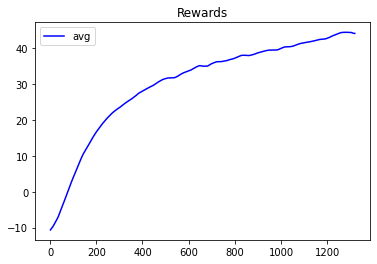

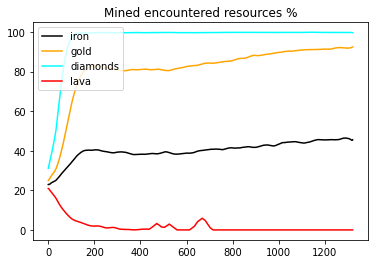

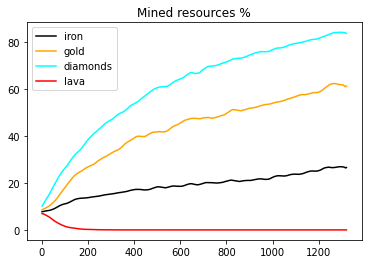

[4:55:47]>[6:04:13] episode 1325, avg score 43.334296875, epsilon 0.1
[4:56:58]>[6:03:02] episode 1330, avg score 43.385078125, epsilon 0.1
[4:58:12]>[6:01:48] episode 1335, avg score 43.43703125, epsilon 0.1
[4:59:28]>[6:00:32] episode 1340, avg score 43.4934375, epsilon 0.1
[5:00:43]>[5:59:17] episode 1345, avg score 43.58609375, epsilon 0.1
[5:01:58]>[5:58:02] episode 1350, avg score 43.6740625, epsilon 0.1
[5:03:14]>[5:56:46] episode 1355, avg score 43.766484375, epsilon 0.1
[5:04:29]>[5:55:31] episode 1360, avg score 43.837578125, epsilon 0.1
[5:05:44]>[5:54:16] episode 1365, avg score 43.88109375, epsilon 0.1
[5:07:00]>[5:53:00] episode 1370, avg score 43.934765625, epsilon 0.1
[5:08:17]>[5:51:43] episode 1375, avg score 44.004296875, epsilon 0.1
[5:09:33]>[5:50:27] episode 1380, avg score 44.05546875, epsilon 0.1


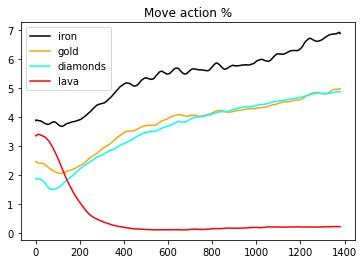

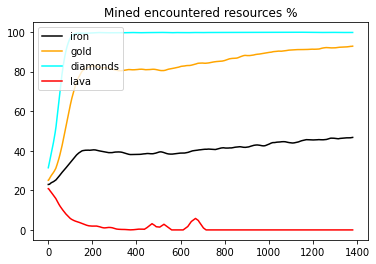

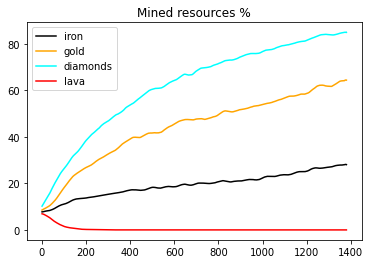

[5:10:53]>[5:49:07] episode 1385, avg score 44.145078125, epsilon 0.1
[5:12:09]>[5:47:51] episode 1390, avg score 44.23296875, epsilon 0.1
[5:13:27]>[5:46:33] episode 1395, avg score 44.33734375, epsilon 0.1
[5:14:44]>[5:45:16] episode 1400, avg score 44.3971875, epsilon 0.1
[5:16:00]>[5:44:00] episode 1405, avg score 44.450546875, epsilon 0.1
[5:17:16]>[5:42:44] episode 1410, avg score 44.4875, epsilon 0.1
[5:18:33]>[5:41:27] episode 1415, avg score 44.55609375, epsilon 0.1
[5:19:49]>[5:40:11] episode 1420, avg score 44.59890625, epsilon 0.1
[5:21:05]>[5:38:55] episode 1425, avg score 44.619296875, epsilon 0.1
[5:22:21]>[5:37:39] episode 1430, avg score 44.664296875, epsilon 0.1
[5:23:37]>[5:36:23] episode 1435, avg score 44.74796875, epsilon 0.1
[5:24:53]>[5:35:07] episode 1440, avg score 44.77890625, epsilon 0.1


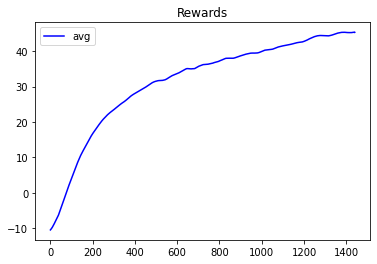

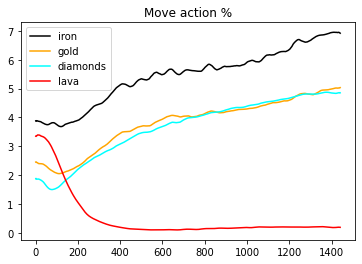

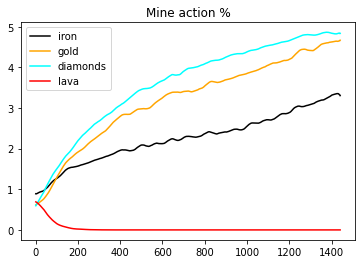

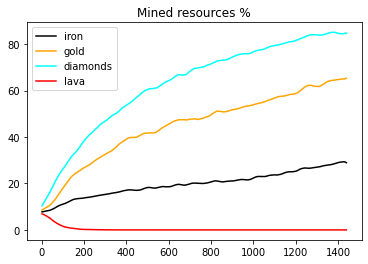

[5:26:11]>[5:33:49] episode 1445, avg score 44.82703125, epsilon 0.1
[5:27:27]>[5:32:33] episode 1450, avg score 44.854453125, epsilon 0.1
[5:28:43]>[5:31:17] episode 1455, avg score 44.920390625, epsilon 0.1
[5:29:59]>[5:30:01] episode 1460, avg score 44.94734375, epsilon 0.1
[5:31:15]>[5:28:45] episode 1465, avg score 44.969921875, epsilon 0.1
[5:32:30]>[5:27:30] episode 1470, avg score 45.024453125, epsilon 0.1
[5:33:46]>[5:26:14] episode 1475, avg score 45.11, epsilon 0.1
[5:35:02]>[5:24:58] episode 1480, avg score 45.14140625, epsilon 0.1
[5:36:18]>[5:23:42] episode 1485, avg score 45.186875, epsilon 0.1
[5:37:33]>[5:22:27] episode 1490, avg score 45.225703125, epsilon 0.1
[5:38:49]>[5:21:11] episode 1495, avg score 45.275390625, epsilon 0.1
[5:40:05]>[5:19:55] episode 1500, avg score 45.33546875, epsilon 0.1


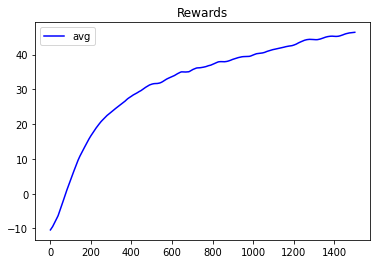

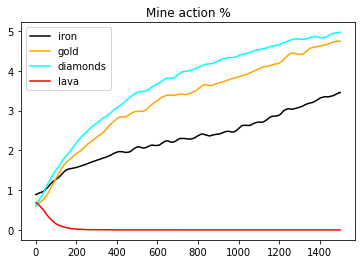

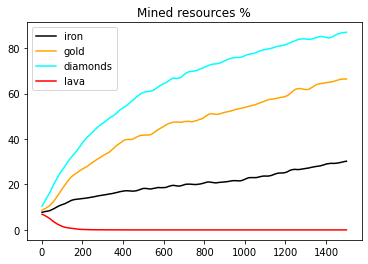

[5:41:24]>[5:18:36] episode 1505, avg score 45.374140625, epsilon 0.1
[5:42:39]>[5:17:21] episode 1510, avg score 45.414765625, epsilon 0.1
[5:43:55]>[5:16:05] episode 1515, avg score 45.516015625, epsilon 0.1
[5:45:09]>[5:14:51] episode 1520, avg score 45.576171875, epsilon 0.1
[5:46:19]>[5:13:41] episode 1525, avg score 45.62984375, epsilon 0.1
[5:47:30]>[5:12:30] episode 1530, avg score 45.651875, epsilon 0.1
[5:48:41]>[5:11:19] episode 1535, avg score 45.69734375, epsilon 0.1
[5:49:52]>[5:10:08] episode 1540, avg score 45.77, epsilon 0.1
[5:51:04]>[5:08:56] episode 1545, avg score 45.83421875, epsilon 0.1
[5:52:16]>[5:07:44] episode 1550, avg score 45.890703125, epsilon 0.1
[5:53:28]>[5:06:32] episode 1555, avg score 45.935859375, epsilon 0.1
[5:54:40]>[5:05:20] episode 1560, avg score 45.961484375, epsilon 0.1


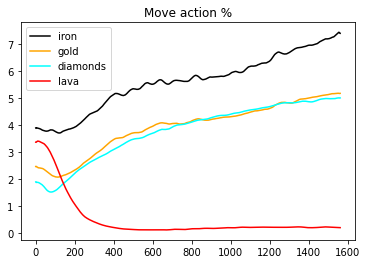

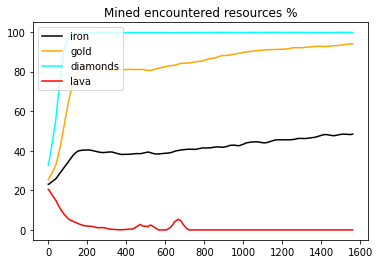

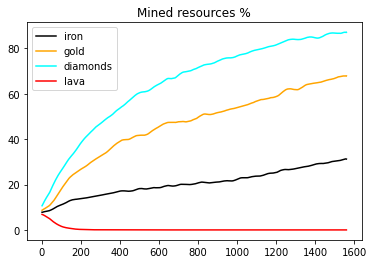

[5:55:55]>[5:04:05] episode 1565, avg score 46.01921875, epsilon 0.1
[5:57:07]>[5:02:53] episode 1570, avg score 46.092109375, epsilon 0.1
[5:58:19]>[5:01:41] episode 1575, avg score 46.114140625, epsilon 0.1
[5:59:31]>[5:00:29] episode 1580, avg score 46.183359375, epsilon 0.1
[6:00:43]>[4:59:17] episode 1585, avg score 46.22203125, epsilon 0.1
[6:01:54]>[4:58:06] episode 1590, avg score 46.24328125, epsilon 0.1
[6:03:04]>[4:56:56] episode 1595, avg score 46.275703125, epsilon 0.1
[6:04:16]>[4:55:44] episode 1600, avg score 46.3603125, epsilon 0.1
[6:05:28]>[4:54:32] episode 1605, avg score 46.422109375, epsilon 0.1
[6:06:40]>[4:53:20] episode 1610, avg score 46.4903125, epsilon 0.1
[6:07:54]>[4:52:06] episode 1615, avg score 46.548671875, epsilon 0.1
[6:09:06]>[4:50:54] episode 1620, avg score 46.60421875, epsilon 0.1


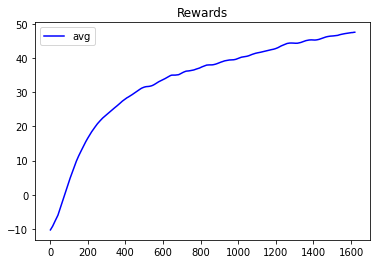

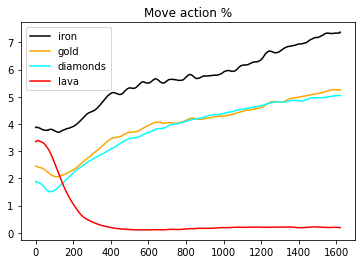

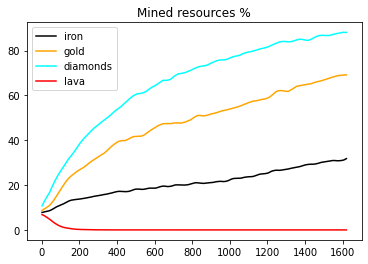

[6:10:23]>[4:49:37] episode 1625, avg score 46.664609375, epsilon 0.1
[6:11:36]>[4:48:24] episode 1630, avg score 46.727265625, epsilon 0.1
[6:12:49]>[4:47:11] episode 1635, avg score 46.771796875, epsilon 0.1
[6:14:02]>[4:45:58] episode 1640, avg score 46.842890625, epsilon 0.1
[6:15:16]>[4:44:44] episode 1645, avg score 46.9046875, epsilon 0.1
[6:16:30]>[4:43:30] episode 1650, avg score 46.946328125, epsilon 0.1
[6:17:44]>[4:42:16] episode 1655, avg score 46.9821875, epsilon 0.1
[6:18:57]>[4:41:03] episode 1660, avg score 47.0390625, epsilon 0.1
[6:20:10]>[4:39:50] episode 1665, avg score 47.07859375, epsilon 0.1
[6:21:23]>[4:38:37] episode 1670, avg score 47.12671875, epsilon 0.1
[6:22:35]>[4:37:25] episode 1675, avg score 47.12828125, epsilon 0.1
[6:23:47]>[4:36:13] episode 1680, avg score 47.16125, epsilon 0.1


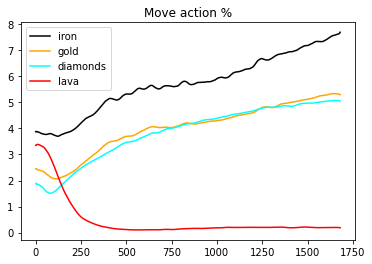

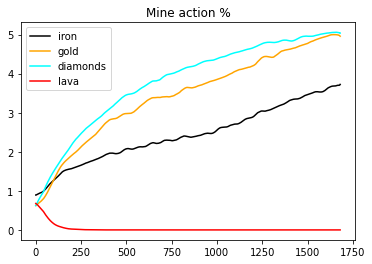

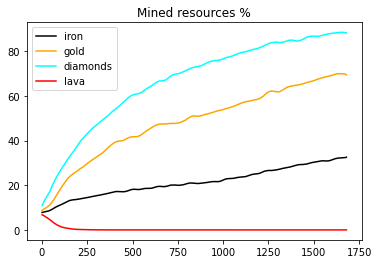

[6:25:02]>[4:34:58] episode 1685, avg score 47.21828125, epsilon 0.1
[6:26:14]>[4:33:46] episode 1690, avg score 47.268984375, epsilon 0.1
[6:27:26]>[4:32:34] episode 1695, avg score 47.3215625, epsilon 0.1
[6:28:38]>[4:31:22] episode 1700, avg score 47.366640625, epsilon 0.1
[6:29:52]>[4:30:08] episode 1705, avg score 47.41671875, epsilon 0.1
[6:31:05]>[4:28:55] episode 1710, avg score 47.462265625, epsilon 0.1
[6:32:18]>[4:27:42] episode 1715, avg score 47.50296875, epsilon 0.1
[6:33:30]>[4:26:30] episode 1720, avg score 47.525625, epsilon 0.1
[6:34:43]>[4:25:17] episode 1725, avg score 47.568828125, epsilon 0.1
[6:35:54]>[4:24:06] episode 1730, avg score 47.667890625, epsilon 0.1
[6:37:07]>[4:22:53] episode 1735, avg score 47.725, epsilon 0.1
[6:38:20]>[4:21:40] episode 1740, avg score 47.75375, epsilon 0.1


[6:39:37]>[4:20:23] episode 1745, avg score 47.773515625, epsilon 0.1
[6:40:52]>[4:19:08] episode 1750, avg score 47.829140625, epsilon 0.1
[6:42:07]>[4:17:53] episode 1755, avg score 47.87171875, epsilon 0.1
[6:43:21]>[4:16:39] episode 1760, avg score 47.9159375, epsilon 0.1
[6:44:33]>[4:15:27] episode 1765, avg score 47.947578125, epsilon 0.1
[6:45:45]>[4:14:15] episode 1770, avg score 47.96375, epsilon 0.1
[6:46:58]>[4:13:02] episode 1775, avg score 48.0121875, epsilon 0.1
[6:48:10]>[4:11:50] episode 1780, avg score 48.02953125, epsilon 0.1
[6:49:22]>[4:10:38] episode 1785, avg score 48.07859375, epsilon 0.1
[6:50:35]>[4:09:25] episode 1790, avg score 48.13390625, epsilon 0.1
[6:51:48]>[4:08:12] episode 1795, avg score 48.185234375, epsilon 0.1
[6:53:01]>[4:06:59] episode 1800, avg score 48.19171875, epsilon 0.1


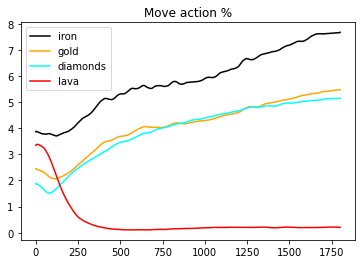

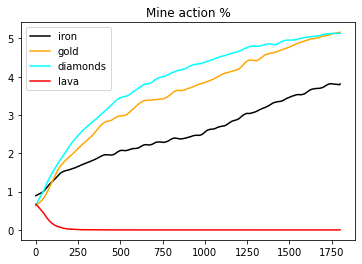

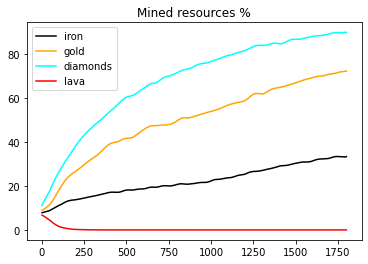

[6:54:18]>[4:05:42] episode 1805, avg score 48.228046875, epsilon 0.1
[6:55:31]>[4:04:29] episode 1810, avg score 48.271015625, epsilon 0.1
[6:56:44]>[4:03:16] episode 1815, avg score 48.31578125, epsilon 0.1
[6:57:57]>[4:02:03] episode 1820, avg score 48.363515625, epsilon 0.1
[6:59:09]>[4:00:51] episode 1825, avg score 48.420546875, epsilon 0.1
[7:00:22]>[3:59:38] episode 1830, avg score 48.44390625, epsilon 0.1
[7:01:36]>[3:58:24] episode 1835, avg score 48.502578125, epsilon 0.1
[7:02:49]>[3:57:11] episode 1840, avg score 48.53734375, epsilon 0.1
[7:04:02]>[3:55:58] episode 1845, avg score 48.593046875, epsilon 0.1
[7:05:15]>[3:54:45] episode 1850, avg score 48.62546875, epsilon 0.1
[7:06:29]>[3:53:31] episode 1855, avg score 48.673125, epsilon 0.1
[7:07:44]>[3:52:16] episode 1860, avg score 48.693984375, epsilon 0.1


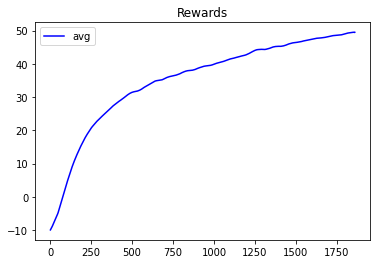

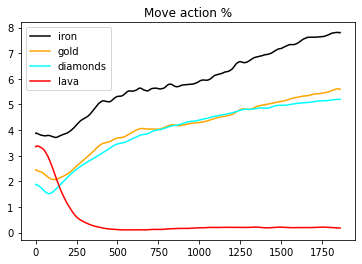

[7:09:01]>[3:50:59] episode 1865, avg score 48.744296875, epsilon 0.1
[7:10:14]>[3:49:46] episode 1870, avg score 48.78625, epsilon 0.1
[7:11:27]>[3:48:33] episode 1875, avg score 48.83796875, epsilon 0.1
[7:12:42]>[3:47:18] episode 1880, avg score 48.9090625, epsilon 0.1
[7:13:55]>[3:46:05] episode 1885, avg score 48.9253125, epsilon 0.1
[7:15:08]>[3:44:52] episode 1890, avg score 48.932890625, epsilon 0.1
[7:16:21]>[3:43:39] episode 1895, avg score 48.945859375, epsilon 0.1
[7:17:33]>[3:42:27] episode 1900, avg score 49.0059375, epsilon 0.1
[7:18:46]>[3:41:14] episode 1905, avg score 49.04625, epsilon 0.1
[7:19:58]>[3:40:02] episode 1910, avg score 49.0875, epsilon 0.1
[7:21:11]>[3:38:49] episode 1915, avg score 49.121796875, epsilon 0.1
[7:22:23]>[3:37:37] episode 1920, avg score 49.18453125, epsilon 0.1


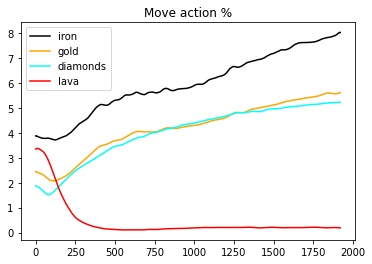

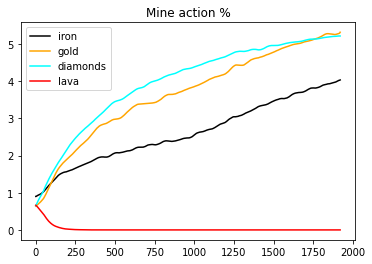

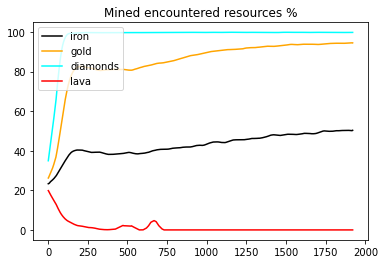

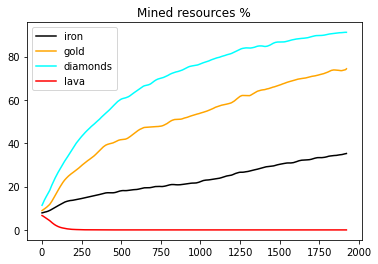

[7:23:40]>[3:36:20] episode 1925, avg score 49.209453125, epsilon 0.1
[7:24:53]>[3:35:07] episode 1930, avg score 49.22140625, epsilon 0.1
[7:26:03]>[3:33:57] episode 1935, avg score 49.2353125, epsilon 0.1
[7:27:15]>[3:32:45] episode 1940, avg score 49.268515625, epsilon 0.1
[7:28:27]>[3:31:33] episode 1945, avg score 49.311484375, epsilon 0.1
[7:29:37]>[3:30:23] episode 1950, avg score 49.305625, epsilon 0.1
[7:30:48]>[3:29:12] episode 1955, avg score 49.328125, epsilon 0.1
[7:31:59]>[3:28:01] episode 1960, avg score 49.35734375, epsilon 0.1
[7:33:11]>[3:26:49] episode 1965, avg score 49.412578125, epsilon 0.1
[7:34:22]>[3:25:38] episode 1970, avg score 49.426640625, epsilon 0.1
[7:35:32]>[3:24:28] episode 1975, avg score 49.4746875, epsilon 0.1
[7:36:43]>[3:23:17] episode 1980, avg score 49.513984375, epsilon 0.1


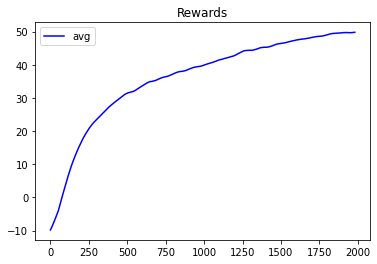

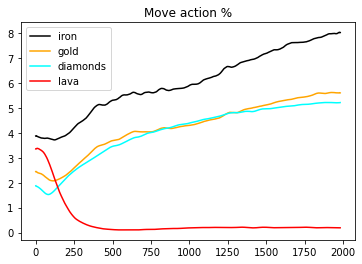

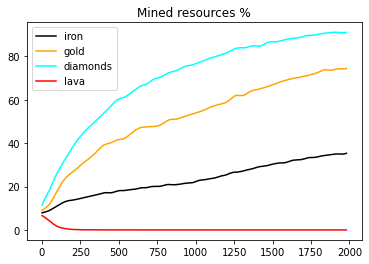

[7:37:58]>[3:22:02] episode 1985, avg score 49.516875, epsilon 0.1
[7:39:09]>[3:20:51] episode 1990, avg score 49.53234375, epsilon 0.1
[7:40:20]>[3:19:40] episode 1995, avg score 49.535546875, epsilon 0.1
[7:41:32]>[3:18:28] episode 2000, avg score 49.57734375, epsilon 0.1
[7:42:44]>[3:17:16] episode 2005, avg score 49.58296875, epsilon 0.1
[7:43:56]>[3:16:04] episode 2010, avg score 49.62375, epsilon 0.1
[7:45:08]>[3:14:52] episode 2015, avg score 49.63109375, epsilon 0.1
[7:46:20]>[3:13:40] episode 2020, avg score 49.63359375, epsilon 0.1
[7:47:32]>[3:12:28] episode 2025, avg score 49.65578125, epsilon 0.1
[7:48:44]>[3:11:16] episode 2030, avg score 49.695859375, epsilon 0.1
[7:49:56]>[3:10:04] episode 2035, avg score 49.70484375, epsilon 0.1
[7:51:08]>[3:08:52] episode 2040, avg score 49.7253125, epsilon 0.1


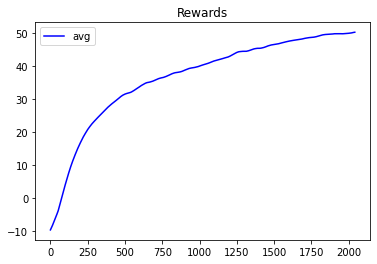

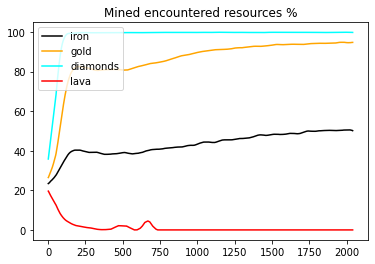

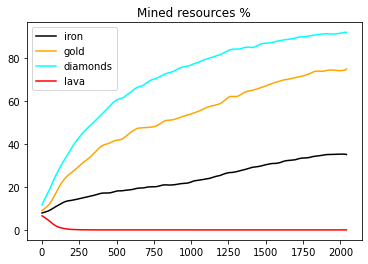

[7:52:23]>[3:07:37] episode 2045, avg score 49.734765625, epsilon 0.1
[7:53:34]>[3:06:26] episode 2050, avg score 49.76765625, epsilon 0.1
[7:54:46]>[3:05:14] episode 2055, avg score 49.78421875, epsilon 0.1
[7:55:57]>[3:04:03] episode 2060, avg score 49.805078125, epsilon 0.1
[7:57:09]>[3:02:51] episode 2065, avg score 49.833125, epsilon 0.1
[7:58:23]>[3:01:37] episode 2070, avg score 49.840078125, epsilon 0.1
[7:59:41]>[3:00:19] episode 2075, avg score 49.8728125, epsilon 0.1
[8:00:57]>[2:59:03] episode 2080, avg score 49.891875, epsilon 0.1
[8:02:14]>[2:57:46] episode 2085, avg score 49.913515625, epsilon 0.1
[8:03:31]>[2:56:29] episode 2090, avg score 49.966484375, epsilon 0.1
[8:04:48]>[2:55:12] episode 2095, avg score 50.017421875, epsilon 0.1
[8:06:04]>[2:53:56] episode 2100, avg score 50.00390625, epsilon 0.1


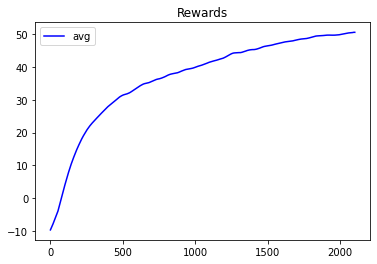

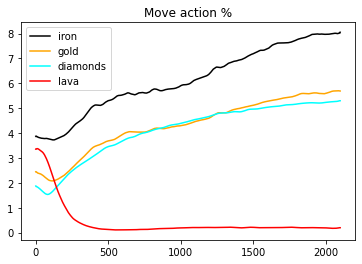

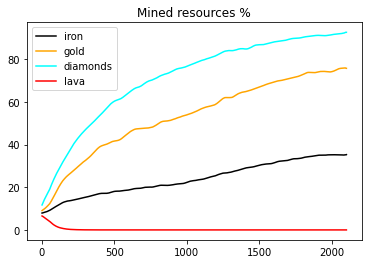

[8:07:25]>[2:52:35] episode 2105, avg score 49.993984375, epsilon 0.1
[8:08:42]>[2:51:18] episode 2110, avg score 49.993828125, epsilon 0.1
[8:10:01]>[2:49:59] episode 2115, avg score 50.008125, epsilon 0.1
[8:11:19]>[2:48:41] episode 2120, avg score 50.000234375, epsilon 0.1
[8:12:37]>[2:47:23] episode 2125, avg score 50.032109375, epsilon 0.1
[8:13:54]>[2:46:06] episode 2130, avg score 50.0496875, epsilon 0.1
[8:15:11]>[2:44:49] episode 2135, avg score 50.08015625, epsilon 0.1
[8:16:28]>[2:43:32] episode 2140, avg score 50.081171875, epsilon 0.1
[8:17:47]>[2:42:13] episode 2145, avg score 50.083125, epsilon 0.1
[8:19:04]>[2:40:56] episode 2150, avg score 50.100859375, epsilon 0.1
[8:20:22]>[2:39:38] episode 2155, avg score 50.11125, epsilon 0.1
[8:21:40]>[2:38:20] episode 2160, avg score 50.138359375, epsilon 0.1


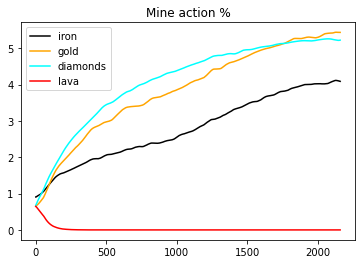

[8:23:01]>[2:36:59] episode 2165, avg score 50.14984375, epsilon 0.1
[8:24:20]>[2:35:40] episode 2170, avg score 50.164375, epsilon 0.1
[8:25:40]>[2:34:20] episode 2175, avg score 50.16171875, epsilon 0.1
[8:26:58]>[2:33:02] episode 2180, avg score 50.17671875, epsilon 0.1
[8:28:17]>[2:31:43] episode 2185, avg score 50.21984375, epsilon 0.1
[8:29:38]>[2:30:22] episode 2190, avg score 50.224375, epsilon 0.1
[8:31:01]>[2:28:59] episode 2195, avg score 50.279375, epsilon 0.1
[8:32:21]>[2:27:39] episode 2200, avg score 50.27296875, epsilon 0.1
[8:33:42]>[2:26:18] episode 2205, avg score 50.305234375, epsilon 0.1
[8:35:03]>[2:24:57] episode 2210, avg score 50.317265625, epsilon 0.1
[8:36:24]>[2:23:36] episode 2215, avg score 50.348203125, epsilon 0.1
[8:37:46]>[2:22:14] episode 2220, avg score 50.401328125, epsilon 0.1


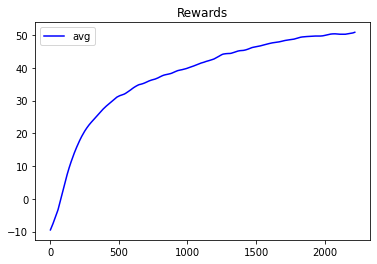

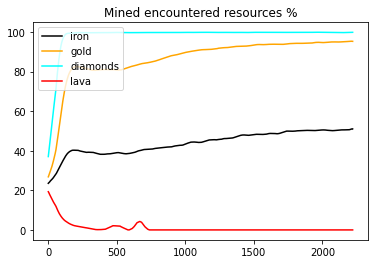

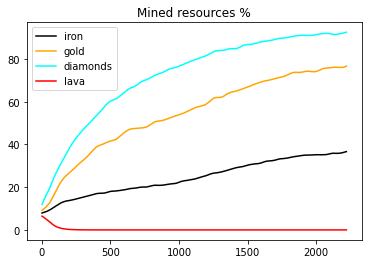

[8:39:11]>[2:20:49] episode 2225, avg score 50.404140625, epsilon 0.1
[8:40:34]>[2:19:26] episode 2230, avg score 50.391640625, epsilon 0.1
[8:41:58]>[2:18:02] episode 2235, avg score 50.4146875, epsilon 0.1
[8:43:21]>[2:16:39] episode 2240, avg score 50.41890625, epsilon 0.1
[8:44:44]>[2:15:16] episode 2245, avg score 50.43421875, epsilon 0.1
[8:46:07]>[2:13:53] episode 2250, avg score 50.443203125, epsilon 0.1
[8:47:30]>[2:12:30] episode 2255, avg score 50.45015625, epsilon 0.1
[8:48:54]>[2:11:06] episode 2260, avg score 50.487265625, epsilon 0.1
[8:50:15]>[2:09:45] episode 2265, avg score 50.491171875, epsilon 0.1
[8:51:38]>[2:08:22] episode 2270, avg score 50.5209375, epsilon 0.1
[8:53:01]>[2:06:59] episode 2275, avg score 50.520390625, epsilon 0.1
[8:54:25]>[2:05:35] episode 2280, avg score 50.531015625, epsilon 0.1


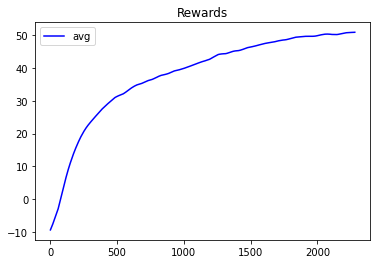

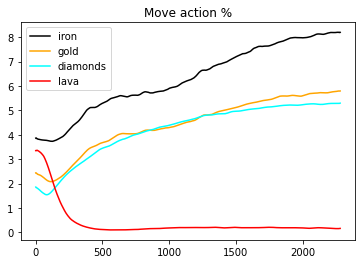

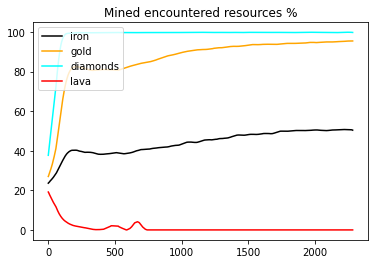

[8:55:51]>[2:04:09] episode 2285, avg score 50.583125, epsilon 0.1
[8:57:17]>[2:02:43] episode 2290, avg score 50.548125, epsilon 0.1
[8:58:38]>[2:01:22] episode 2295, avg score 50.544765625, epsilon 0.1
[9:00:00]>[2:00:00] episode 2300, avg score 50.556953125, epsilon 0.1
[9:01:22]>[1:58:38] episode 2305, avg score 50.57, epsilon 0.1
[9:02:44]>[1:57:16] episode 2310, avg score 50.609609375, epsilon 0.1
[9:04:05]>[1:55:55] episode 2315, avg score 50.619453125, epsilon 0.1
[9:05:27]>[1:54:33] episode 2320, avg score 50.6415625, epsilon 0.1
[9:06:46]>[1:53:14] episode 2325, avg score 50.639375, epsilon 0.1
[9:08:01]>[1:51:59] episode 2330, avg score 50.65390625, epsilon 0.1
[9:09:17]>[1:50:43] episode 2335, avg score 50.6640625, epsilon 0.1
[9:10:32]>[1:49:28] episode 2340, avg score 50.687578125, epsilon 0.1


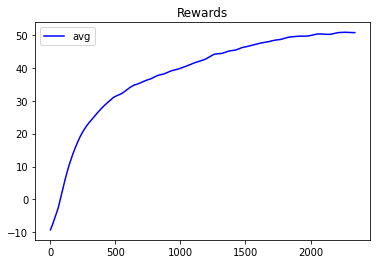

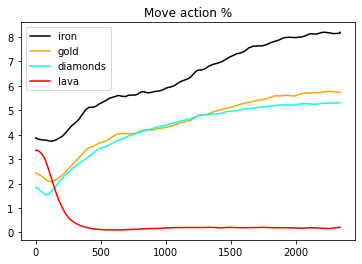

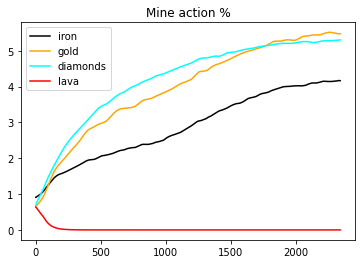

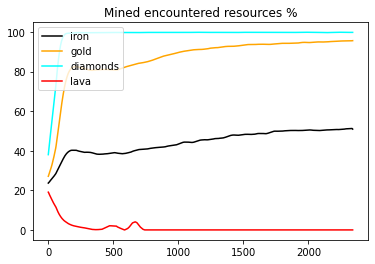

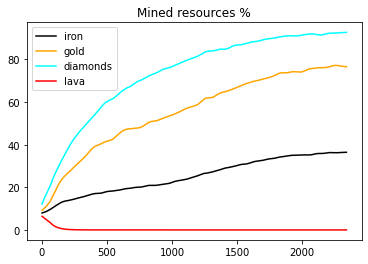

[9:11:54]>[1:48:06] episode 2345, avg score 50.7225, epsilon 0.1
[9:13:11]>[1:46:49] episode 2350, avg score 50.751796875, epsilon 0.1
[9:14:28]>[1:45:32] episode 2355, avg score 50.766640625, epsilon 0.1
[9:15:45]>[1:44:15] episode 2360, avg score 50.787734375, epsilon 0.1
[9:17:04]>[1:42:56] episode 2365, avg score 50.802421875, epsilon 0.1
[9:18:24]>[1:41:36] episode 2370, avg score 50.823125, epsilon 0.1
[9:19:42]>[1:40:18] episode 2375, avg score 50.848671875, epsilon 0.1
[9:20:57]>[1:39:03] episode 2380, avg score 50.8621875, epsilon 0.1
[9:22:15]>[1:37:45] episode 2385, avg score 50.84890625, epsilon 0.1
[9:23:32]>[1:36:28] episode 2390, avg score 50.87640625, epsilon 0.1
[9:24:49]>[1:35:11] episode 2395, avg score 50.886796875, epsilon 0.1
[9:26:04]>[1:33:56] episode 2400, avg score 50.912578125, epsilon 0.1


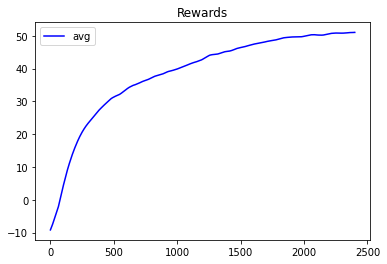

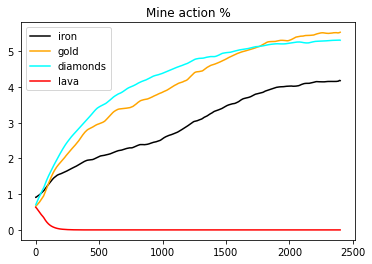

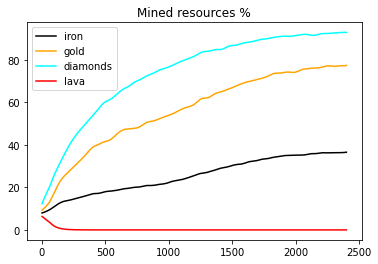

[9:27:27]>[1:32:33] episode 2405, avg score 50.93359375, epsilon 0.1
[9:28:44]>[1:31:16] episode 2410, avg score 50.918984375, epsilon 0.1
[9:30:01]>[1:29:59] episode 2415, avg score 50.904765625, epsilon 0.1
[9:31:18]>[1:28:42] episode 2420, avg score 50.8990625, epsilon 0.1
[9:32:35]>[1:27:25] episode 2425, avg score 50.905703125, epsilon 0.1
[9:33:51]>[1:26:09] episode 2430, avg score 50.9353125, epsilon 0.1
[9:35:06]>[1:24:54] episode 2435, avg score 50.925, epsilon 0.1
[9:36:20]>[1:23:40] episode 2440, avg score 50.93859375, epsilon 0.1
[9:37:33]>[1:22:27] episode 2445, avg score 50.93765625, epsilon 0.1
[9:38:48]>[1:21:12] episode 2450, avg score 50.925, epsilon 0.1
[9:40:00]>[1:20:00] episode 2455, avg score 50.926875, epsilon 0.1
[9:41:13]>[1:18:47] episode 2460, avg score 50.90109375, epsilon 0.1


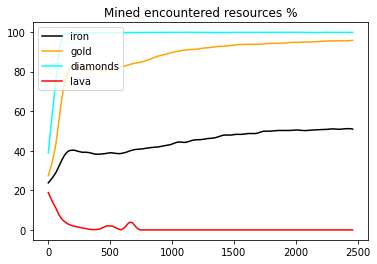

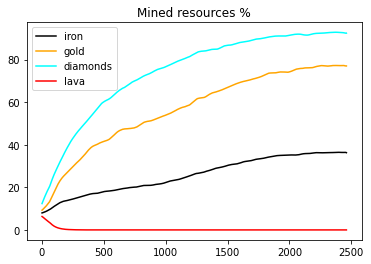

[9:42:30]>[1:17:30] episode 2465, avg score 50.912109375, epsilon 0.1
[9:43:43]>[1:16:17] episode 2470, avg score 50.9146875, epsilon 0.1
[9:44:55]>[1:15:05] episode 2475, avg score 50.92390625, epsilon 0.1
[9:46:06]>[1:13:54] episode 2480, avg score 50.9240625, epsilon 0.1
[9:47:18]>[1:12:42] episode 2485, avg score 50.878984375, epsilon 0.1
[9:48:31]>[1:11:29] episode 2490, avg score 50.91953125, epsilon 0.1
[9:49:42]>[1:10:18] episode 2495, avg score 50.923671875, epsilon 0.1
[9:50:53]>[1:09:07] episode 2500, avg score 50.943203125, epsilon 0.1
[9:52:05]>[1:07:55] episode 2505, avg score 50.97609375, epsilon 0.1
[9:53:17]>[1:06:43] episode 2510, avg score 50.96921875, epsilon 0.1
[9:54:28]>[1:05:32] episode 2515, avg score 50.964375, epsilon 0.1
[9:55:40]>[1:04:20] episode 2520, avg score 50.979140625, epsilon 0.1


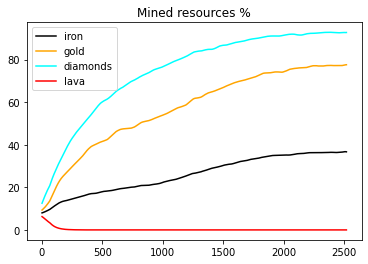

[9:56:57]>[1:03:03] episode 2525, avg score 50.981171875, epsilon 0.1
[9:58:09]>[1:01:51] episode 2530, avg score 50.98703125, epsilon 0.1
[9:59:22]>[1:00:38] episode 2535, avg score 50.99453125, epsilon 0.1
[10:00:33]>[0:59:27] episode 2540, avg score 51.016171875, epsilon 0.1
[10:01:45]>[0:58:15] episode 2545, avg score 50.99578125, epsilon 0.1
[10:02:56]>[0:57:04] episode 2550, avg score 50.990390625, epsilon 0.1
[10:04:08]>[0:55:52] episode 2555, avg score 50.99828125, epsilon 0.1
[10:05:19]>[0:54:41] episode 2560, avg score 50.98921875, epsilon 0.1
[10:06:31]>[0:53:29] episode 2565, avg score 50.975390625, epsilon 0.1
[10:07:42]>[0:52:18] episode 2570, avg score 50.991640625, epsilon 0.1
[10:08:55]>[0:51:05] episode 2575, avg score 51.011328125, epsilon 0.1
[10:10:07]>[0:49:53] episode 2580, avg score 51.01953125, epsilon 0.1


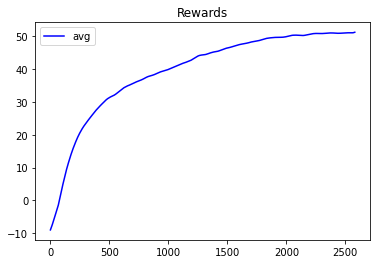

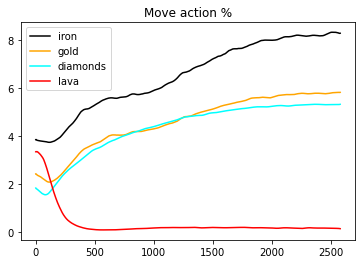

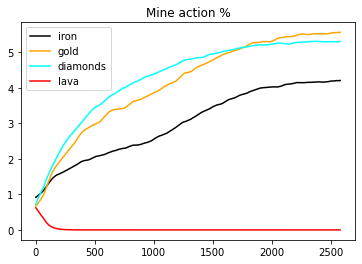

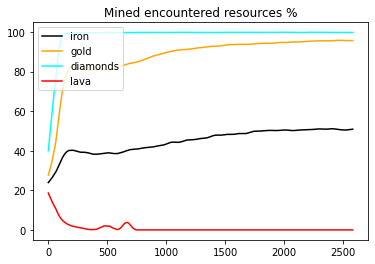

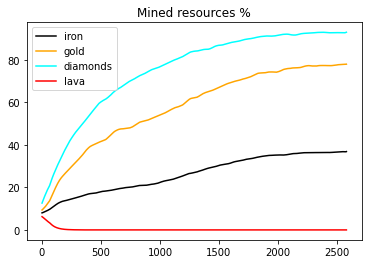

[10:11:23]>[0:48:37] episode 2585, avg score 51.033828125, epsilon 0.1
[10:12:35]>[0:47:25] episode 2590, avg score 51.05046875, epsilon 0.1
[10:13:47]>[0:46:13] episode 2595, avg score 51.043671875, epsilon 0.1
[10:15:00]>[0:45:00] episode 2600, avg score 51.04328125, epsilon 0.1
[10:16:12]>[0:43:48] episode 2605, avg score 51.043671875, epsilon 0.1
[10:17:24]>[0:42:36] episode 2610, avg score 51.0490625, epsilon 0.1
[10:18:37]>[0:41:23] episode 2615, avg score 51.07109375, epsilon 0.1
[10:19:50]>[0:40:10] episode 2620, avg score 51.06609375, epsilon 0.1
[10:21:02]>[0:38:58] episode 2625, avg score 51.081640625, epsilon 0.1
[10:22:14]>[0:37:46] episode 2630, avg score 51.081171875, epsilon 0.1
[10:23:26]>[0:36:34] episode 2635, avg score 51.094453125, epsilon 0.1
[10:24:40]>[0:35:20] episode 2640, avg score 51.111875, epsilon 0.1


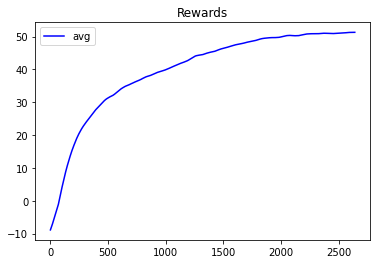

[10:25:56]>[0:34:04] episode 2645, avg score 51.09765625, epsilon 0.1
[10:27:09]>[0:32:51] episode 2650, avg score 51.118515625, epsilon 0.1
[10:28:22]>[0:31:38] episode 2655, avg score 51.13515625, epsilon 0.1
[10:29:36]>[0:30:24] episode 2660, avg score 51.152421875, epsilon 0.1
[10:30:48]>[0:29:12] episode 2665, avg score 51.15046875, epsilon 0.1
[10:32:00]>[0:28:00] episode 2670, avg score 51.150078125, epsilon 0.1
[10:33:12]>[0:26:48] episode 2675, avg score 51.151015625, epsilon 0.1
[10:34:25]>[0:25:35] episode 2680, avg score 51.152734375, epsilon 0.1
[10:35:39]>[0:24:21] episode 2685, avg score 51.174921875, epsilon 0.1
[10:36:51]>[0:23:09] episode 2690, avg score 51.172734375, epsilon 0.1
[10:38:04]>[0:21:56] episode 2695, avg score 51.1571875, epsilon 0.1
[10:39:16]>[0:20:44] episode 2700, avg score 51.150625, epsilon 0.1


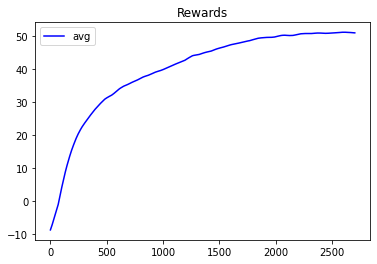

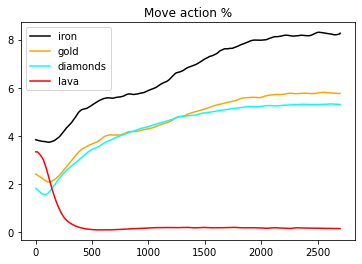

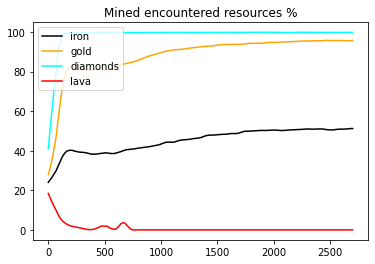

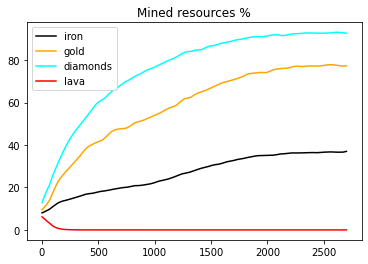

[10:40:34]>[0:19:26] episode 2705, avg score 51.123984375, epsilon 0.1
[10:41:46]>[0:18:14] episode 2710, avg score 51.137890625, epsilon 0.1
[10:42:59]>[0:17:01] episode 2715, avg score 51.1665625, epsilon 0.1
[10:44:12]>[0:15:48] episode 2720, avg score 51.15, epsilon 0.1
[10:45:26]>[0:14:34] episode 2725, avg score 51.153203125, epsilon 0.1
[10:46:39]>[0:13:21] episode 2730, avg score 51.154375, epsilon 0.1
[10:47:52]>[0:12:08] episode 2735, avg score 51.14578125, epsilon 0.1
[10:49:04]>[0:10:56] episode 2740, avg score 51.14375, epsilon 0.1
[10:50:18]>[0:09:42] episode 2745, avg score 51.15796875, epsilon 0.1
[10:51:31]>[0:08:29] episode 2750, avg score 51.1746875, epsilon 0.1
[10:52:44]>[0:07:16] episode 2755, avg score 51.1946875, epsilon 0.1
[10:53:58]>[0:06:02] episode 2760, avg score 51.193046875, epsilon 0.1


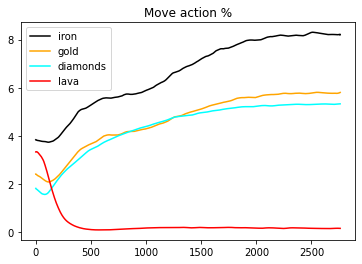

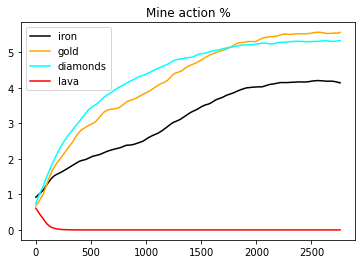

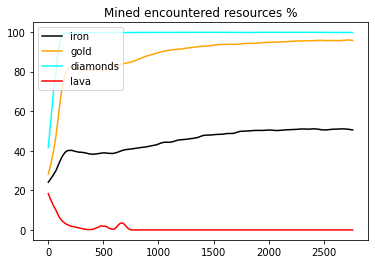

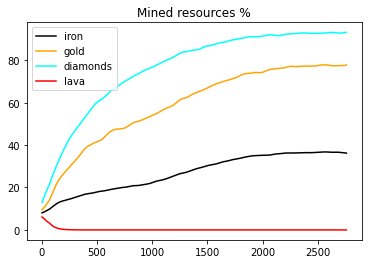

[10:55:16]>[0:04:44] episode 2765, avg score 51.201796875, epsilon 0.1
[10:56:31]>[0:03:29] episode 2770, avg score 51.21046875, epsilon 0.1
[10:57:44]>[0:02:16] episode 2775, avg score 51.192734375, epsilon 0.1
[10:58:57]>[0:01:03] episode 2780, avg score 51.196953125, epsilon 0.1
[11:00:11]>[23:59:50] episode 2785, avg score 51.196015625, epsilon 0.1
Run ended
[11:00:11]>[23:59:50] episode 2786, avg score 51.196015625, epsilon 0.1


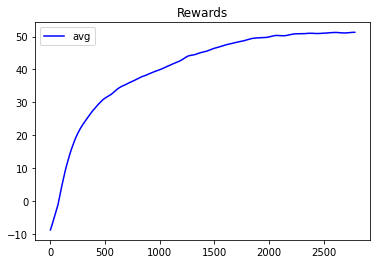

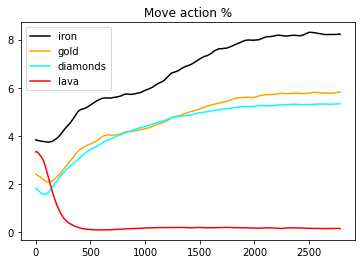

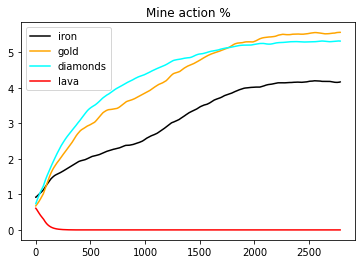

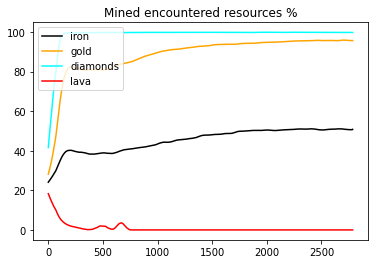

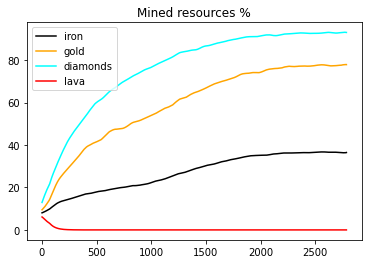

In [ ]:
if RESTORE_CHECKPOINT:
  restore_checkpoint(agent)

agent.enable_random = False
run_train()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0:00:12]>[0:59:48] episode 5, avg score 51.36875, epsilon 0.1
[0:00:27]>[0:59:33] episode 10, avg score 51.4203125, epsilon 0.1
[0:00:42]>[0:59:18] episode 15, avg score 51.184375, epsilon 0.1
[0:00:57]>[0:59:03] episode 20, avg score 51.2828125, epsilon 0.1
[0:01:11]>[0:58:49] episode 25, avg score 51.210625, epsilon 0.1
[0:01:26]>[0:58:34] episode 30, avg score 51.083333333333336, epsilon 0.1
[0:01:41]>[0:58:19] episode 35, avg score 51.18794642857143, epsilon 0.1
[0:01:56]>[0:58:04] episode 40, avg score 51.2421875, epsilon 0.1
[0:02:12]>[0:57:48] episode 45, avg score 51.200694444444444, epsilon 0.1
[0:02:27]>[0:57:33] episode 50, avg score 51.2446875, epsilon 0.1
[0:02:42]>[0:57:18] episode 55, avg score 51.26903409090909, epsilon 0.1
[0:02:57]>[0:57:03] episode 60, avg score 51.243489583333336, epsilon 0.1


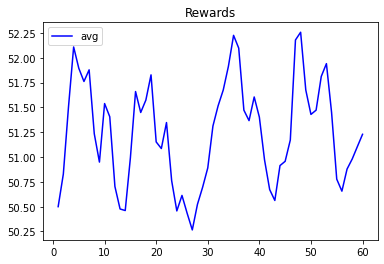

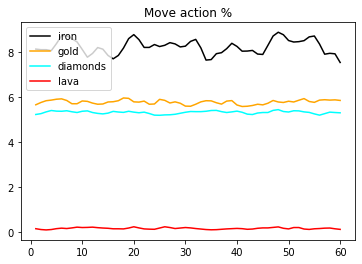

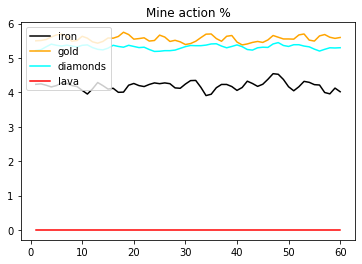

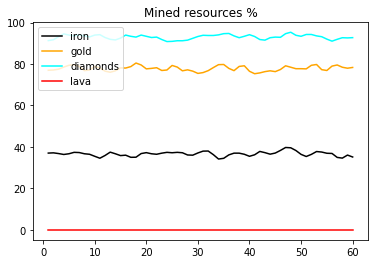

[0:03:13]>[0:56:47] episode 65, avg score 51.23389423076923, epsilon 0.1
[0:03:28]>[0:56:32] episode 70, avg score 51.255580357142854, epsilon 0.1
[0:03:43]>[0:56:17] episode 75, avg score 51.258125, epsilon 0.1
[0:03:58]>[0:56:02] episode 80, avg score 51.25234375, epsilon 0.1
[0:04:13]>[0:55:47] episode 85, avg score 51.27922794117647, epsilon 0.1
[0:04:28]>[0:55:32] episode 90, avg score 51.292881944444446, epsilon 0.1
[0:04:43]>[0:55:17] episode 95, avg score 51.294243421052634, epsilon 0.1
[0:04:58]>[0:55:02] episode 100, avg score 51.31515625, epsilon 0.1
[0:05:13]>[0:54:47] episode 105, avg score 51.303125, epsilon 0.1
[0:05:28]>[0:54:32] episode 110, avg score 51.3015625, epsilon 0.1
[0:05:44]>[0:54:16] episode 115, avg score 51.30910326086956, epsilon 0.1
[0:05:59]>[0:54:01] episode 120, avg score 51.280208333333334, epsilon 0.1


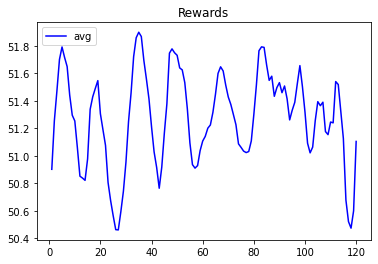

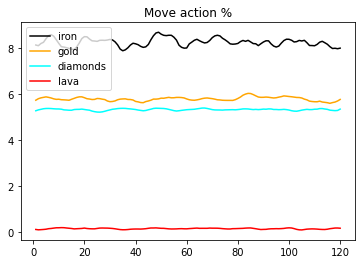

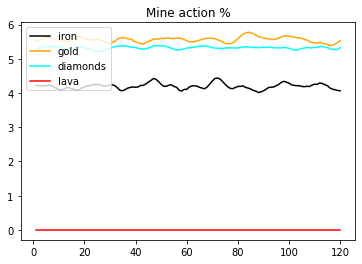

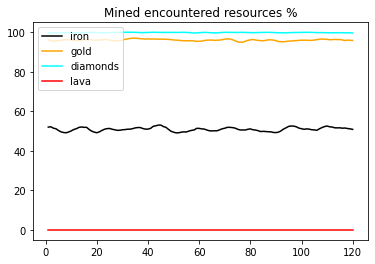

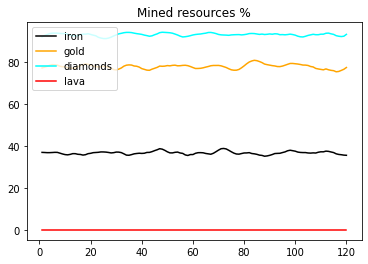

[0:06:14]>[0:53:46] episode 125, avg score 51.283375, epsilon 0.1
[0:06:29]>[0:53:31] episode 130, avg score 51.28305288461539, epsilon 0.1
[0:06:44]>[0:53:16] episode 135, avg score 51.30162037037037, epsilon 0.1
[0:06:59]>[0:53:01] episode 140, avg score 51.2859375, epsilon 0.1
[0:07:14]>[0:52:46] episode 145, avg score 51.29299568965517, epsilon 0.1
[0:07:29]>[0:52:31] episode 150, avg score 51.305104166666666, epsilon 0.1
[0:07:44]>[0:52:16] episode 155, avg score 51.29284274193548, epsilon 0.1
[0:07:59]>[0:52:01] episode 160, avg score 51.29013671875, epsilon 0.1
[0:08:14]>[0:51:46] episode 165, avg score 51.29829545454545, epsilon 0.1
[0:08:29]>[0:51:31] episode 170, avg score 51.29420955882353, epsilon 0.1
[0:08:44]>[0:51:16] episode 175, avg score 51.308928571428574, epsilon 0.1
[0:08:59]>[0:51:01] episode 180, avg score 51.30277777777778, epsilon 0.1


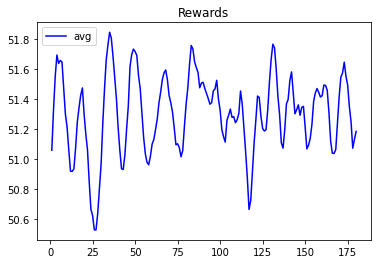

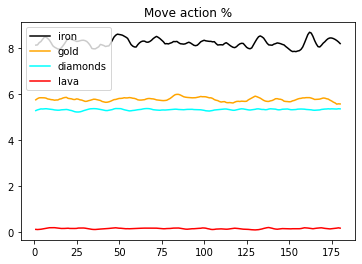

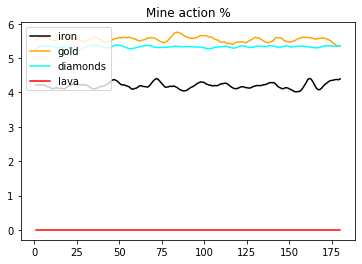

[0:09:15]>[0:50:45] episode 185, avg score 51.31706081081081, epsilon 0.1
[0:09:30]>[0:50:30] episode 190, avg score 51.30230263157895, epsilon 0.1
[0:09:45]>[0:50:15] episode 195, avg score 51.30945512820513, epsilon 0.1
[0:10:00]>[0:50:00] episode 200, avg score 51.30953125, epsilon 0.1
[0:10:15]>[0:49:45] episode 205, avg score 51.310546875, epsilon 0.1
[0:10:30]>[0:49:30] episode 210, avg score 51.301328125, epsilon 0.1
[0:10:45]>[0:49:15] episode 215, avg score 51.309140625, epsilon 0.1
[0:11:01]>[0:48:59] episode 220, avg score 51.308046875, epsilon 0.1
[0:11:16]>[0:48:44] episode 225, avg score 51.32609375, epsilon 0.1
[0:11:31]>[0:48:29] episode 230, avg score 51.36734375, epsilon 0.1
[0:11:46]>[0:48:14] episode 235, avg score 51.36140625, epsilon 0.1
[0:12:01]>[0:47:59] episode 240, avg score 51.33765625, epsilon 0.1


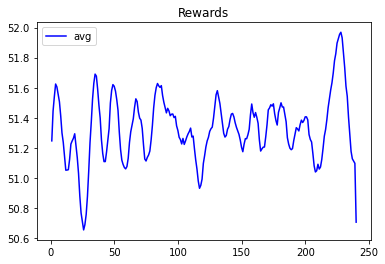

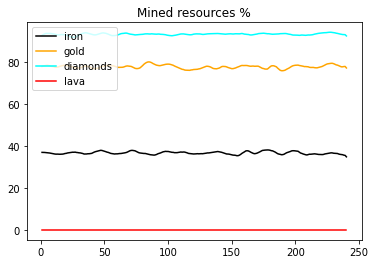

[0:12:17]>[0:47:43] episode 245, avg score 51.343984375, epsilon 0.1
[0:12:32]>[0:47:28] episode 250, avg score 51.354609375, epsilon 0.1
[0:12:47]>[0:47:13] episode 255, avg score 51.34140625, epsilon 0.1
[0:13:02]>[0:46:58] episode 260, avg score 51.3521875, epsilon 0.1
[0:13:17]>[0:46:43] episode 265, avg score 51.33515625, epsilon 0.1
[0:13:32]>[0:46:28] episode 270, avg score 51.325, epsilon 0.1
[0:13:47]>[0:46:13] episode 275, avg score 51.34484375, epsilon 0.1
[0:14:02]>[0:45:58] episode 280, avg score 51.35625, epsilon 0.1
[0:14:17]>[0:45:43] episode 285, avg score 51.35578125, epsilon 0.1
[0:14:32]>[0:45:28] episode 290, avg score 51.3640625, epsilon 0.1
[0:14:47]>[0:45:13] episode 295, avg score 51.38609375, epsilon 0.1
[0:15:02]>[0:44:58] episode 300, avg score 51.358984375, epsilon 0.1


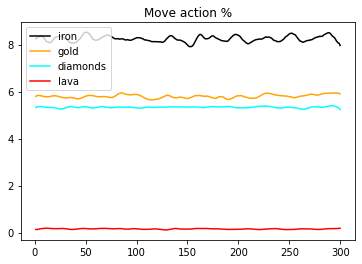

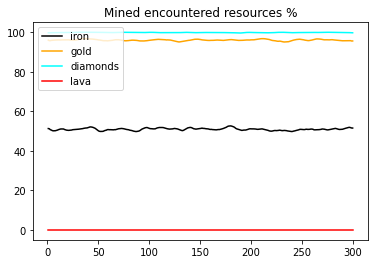

[0:15:19]>[0:44:41] episode 305, avg score 51.37203125, epsilon 0.1
[0:15:34]>[0:44:26] episode 310, avg score 51.353828125, epsilon 0.1
[0:15:49]>[0:44:11] episode 315, avg score 51.37, epsilon 0.1
[0:16:04]>[0:43:56] episode 320, avg score 51.386875, epsilon 0.1
[0:16:19]>[0:43:41] episode 325, avg score 51.372734375, epsilon 0.1
[0:16:34]>[0:43:26] episode 330, avg score 51.38515625, epsilon 0.1
[0:16:49]>[0:43:11] episode 335, avg score 51.365625, epsilon 0.1
[0:17:04]>[0:42:56] episode 340, avg score 51.37859375, epsilon 0.1
[0:17:19]>[0:42:41] episode 345, avg score 51.39890625, epsilon 0.1
[0:17:34]>[0:42:26] episode 350, avg score 51.3840625, epsilon 0.1
[0:17:49]>[0:42:11] episode 355, avg score 51.3909375, epsilon 0.1
[0:18:04]>[0:41:56] episode 360, avg score 51.402734375, epsilon 0.1


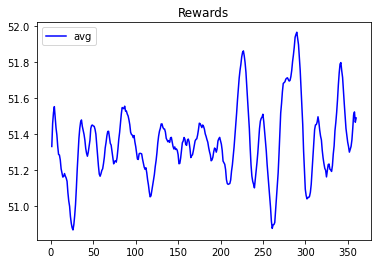

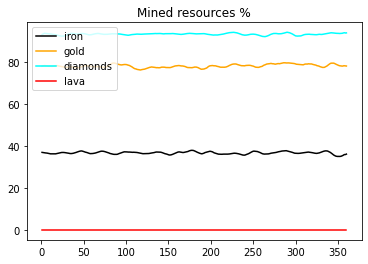

[0:18:20]>[0:41:40] episode 365, avg score 51.39203125, epsilon 0.1
[0:18:35]>[0:41:25] episode 370, avg score 51.38875, epsilon 0.1
[0:18:50]>[0:41:10] episode 375, avg score 51.379140625, epsilon 0.1
[0:19:05]>[0:40:55] episode 380, avg score 51.373203125, epsilon 0.1
[0:19:20]>[0:40:40] episode 385, avg score 51.354375, epsilon 0.1
[0:19:35]>[0:40:25] episode 390, avg score 51.36859375, epsilon 0.1
[0:19:50]>[0:40:10] episode 395, avg score 51.382421875, epsilon 0.1
[0:20:05]>[0:39:55] episode 400, avg score 51.391875, epsilon 0.1
[0:20:20]>[0:39:40] episode 405, avg score 51.383984375, epsilon 0.1
[0:20:35]>[0:39:25] episode 410, avg score 51.383203125, epsilon 0.1
[0:20:50]>[0:39:10] episode 415, avg score 51.38, epsilon 0.1
[0:21:05]>[0:38:55] episode 420, avg score 51.370546875, epsilon 0.1


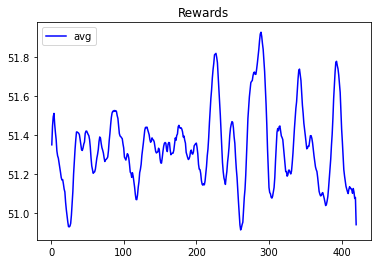

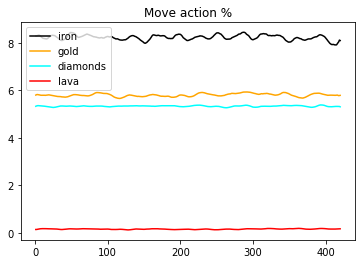

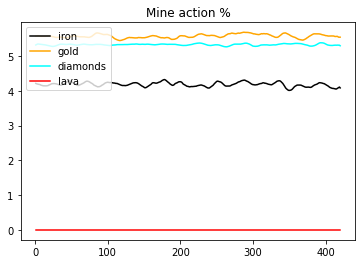

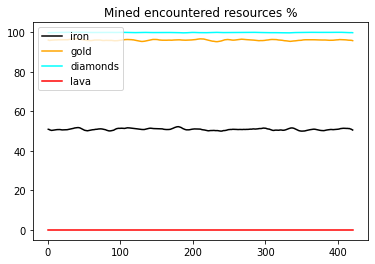

[0:21:21]>[0:38:39] episode 425, avg score 51.364296875, epsilon 0.1
[0:21:36]>[0:38:24] episode 430, avg score 51.347890625, epsilon 0.1
[0:21:51]>[0:38:09] episode 435, avg score 51.3446875, epsilon 0.1
[0:22:06]>[0:37:54] episode 440, avg score 51.3440625, epsilon 0.1
[0:22:21]>[0:37:39] episode 445, avg score 51.347265625, epsilon 0.1
[0:22:36]>[0:37:24] episode 450, avg score 51.34828125, epsilon 0.1
[0:22:50]>[0:37:10] episode 455, avg score 51.35640625, epsilon 0.1
[0:23:05]>[0:36:55] episode 460, avg score 51.365859375, epsilon 0.1
[0:23:20]>[0:36:40] episode 465, avg score 51.375078125, epsilon 0.1
[0:23:36]>[0:36:24] episode 470, avg score 51.375625, epsilon 0.1
[0:23:50]>[0:36:10] episode 475, avg score 51.334375, epsilon 0.1
[0:24:05]>[0:35:55] episode 480, avg score 51.320703125, epsilon 0.1


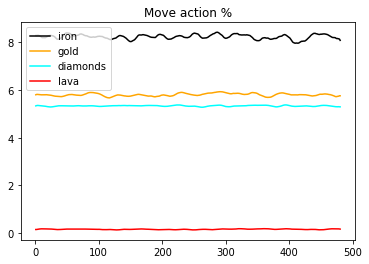

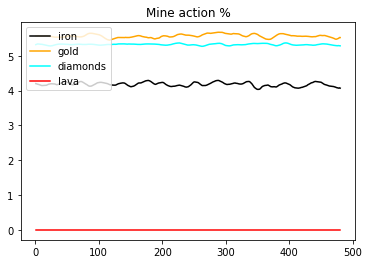

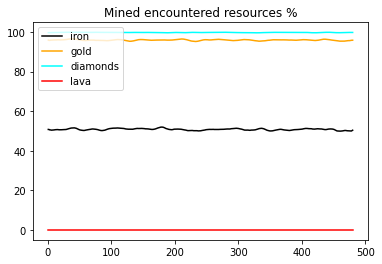

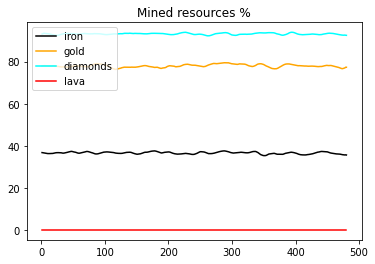

[0:24:21]>[0:35:39] episode 485, avg score 51.3178125, epsilon 0.1
[0:24:36]>[0:35:24] episode 490, avg score 51.31703125, epsilon 0.1
[0:24:51]>[0:35:09] episode 495, avg score 51.2928125, epsilon 0.1
[0:25:06]>[0:34:54] episode 500, avg score 51.2846875, epsilon 0.1
[0:25:21]>[0:34:39] episode 505, avg score 51.272890625, epsilon 0.1
[0:25:36]>[0:34:24] episode 510, avg score 51.294609375, epsilon 0.1
[0:25:51]>[0:34:09] episode 515, avg score 51.27296875, epsilon 0.1
[0:26:06]>[0:33:54] episode 520, avg score 51.28859375, epsilon 0.1
[0:26:21]>[0:33:39] episode 525, avg score 51.32375, epsilon 0.1
[0:26:37]>[0:33:23] episode 530, avg score 51.312265625, epsilon 0.1
[0:26:52]>[0:33:08] episode 535, avg score 51.331875, epsilon 0.1
[0:27:07]>[0:32:53] episode 540, avg score 51.342265625, epsilon 0.1


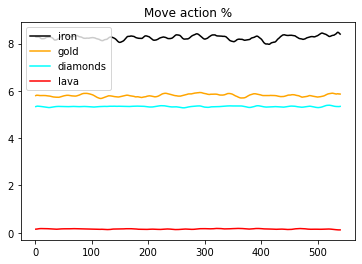

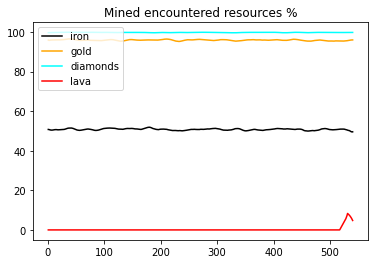

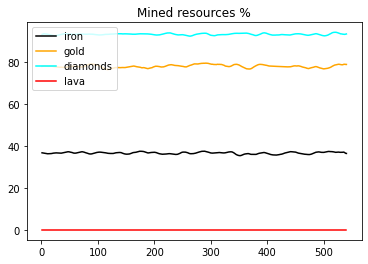

[0:27:24]>[0:32:36] episode 545, avg score 51.313359375, epsilon 0.1
[0:27:38]>[0:32:22] episode 550, avg score 51.31890625, epsilon 0.1
[0:27:53]>[0:32:07] episode 555, avg score 51.333203125, epsilon 0.1
[0:28:09]>[0:31:51] episode 560, avg score 51.3175, epsilon 0.1
[0:28:23]>[0:31:37] episode 565, avg score 51.33390625, epsilon 0.1
[0:28:38]>[0:31:22] episode 570, avg score 51.33046875, epsilon 0.1
[0:28:53]>[0:31:07] episode 575, avg score 51.33859375, epsilon 0.1
[0:29:08]>[0:30:52] episode 580, avg score 51.33546875, epsilon 0.1
[0:29:23]>[0:30:37] episode 585, avg score 51.33703125, epsilon 0.1
[0:29:38]>[0:30:22] episode 590, avg score 51.341640625, epsilon 0.1
[0:29:53]>[0:30:07] episode 595, avg score 51.33171875, epsilon 0.1
[0:30:08]>[0:29:52] episode 600, avg score 51.316640625, epsilon 0.1


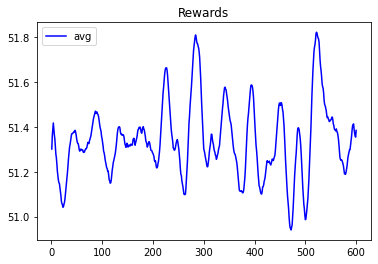

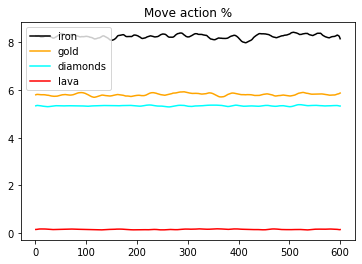

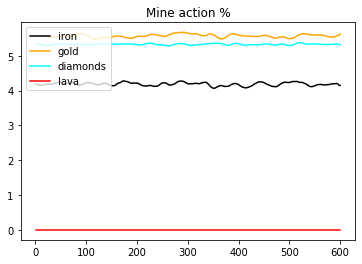

[0:30:25]>[0:29:35] episode 605, avg score 51.301015625, epsilon 0.1
[0:30:39]>[0:29:21] episode 610, avg score 51.31046875, epsilon 0.1
[0:30:54]>[0:29:06] episode 615, avg score 51.31390625, epsilon 0.1
[0:31:08]>[0:28:52] episode 620, avg score 51.318515625, epsilon 0.1
[0:31:23]>[0:28:37] episode 625, avg score 51.3153125, epsilon 0.1
[0:31:38]>[0:28:22] episode 630, avg score 51.30359375, epsilon 0.1
[0:31:53]>[0:28:07] episode 635, avg score 51.3071875, epsilon 0.1
[0:32:07]>[0:27:53] episode 640, avg score 51.3290625, epsilon 0.1
[0:32:22]>[0:27:38] episode 645, avg score 51.32453125, epsilon 0.1
[0:32:37]>[0:27:23] episode 650, avg score 51.291953125, epsilon 0.1
[0:32:51]>[0:27:09] episode 655, avg score 51.2784375, epsilon 0.1
[0:33:06]>[0:26:54] episode 660, avg score 51.263125, epsilon 0.1


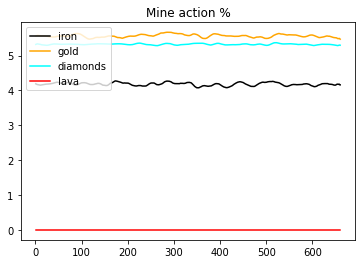

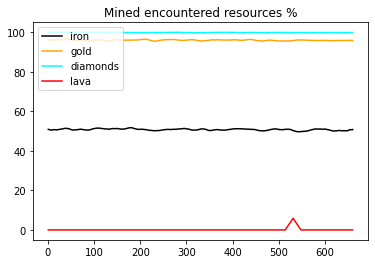

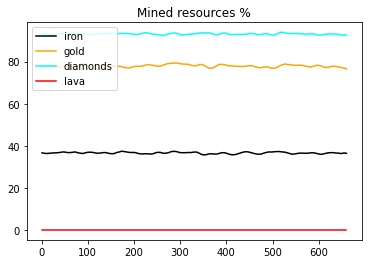

[0:33:22]>[0:26:38] episode 665, avg score 51.27390625, epsilon 0.1
[0:33:37]>[0:26:23] episode 670, avg score 51.28109375, epsilon 0.1
[0:33:52]>[0:26:08] episode 675, avg score 51.292109375, epsilon 0.1
[0:34:07]>[0:25:53] episode 680, avg score 51.2975, epsilon 0.1
[0:34:22]>[0:25:38] episode 685, avg score 51.275, epsilon 0.1
[0:34:37]>[0:25:23] episode 690, avg score 51.28390625, epsilon 0.1
[0:34:52]>[0:25:08] episode 695, avg score 51.2940625, epsilon 0.1
[0:35:07]>[0:24:53] episode 700, avg score 51.32765625, epsilon 0.1
[0:35:22]>[0:24:38] episode 705, avg score 51.33109375, epsilon 0.1
[0:35:37]>[0:24:23] episode 710, avg score 51.323203125, epsilon 0.1
[0:35:52]>[0:24:08] episode 715, avg score 51.32546875, epsilon 0.1
[0:36:07]>[0:23:53] episode 720, avg score 51.314296875, epsilon 0.1


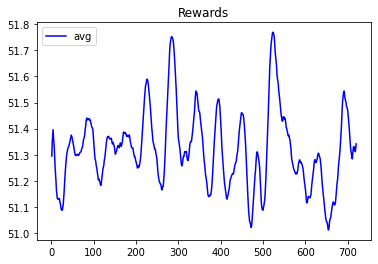

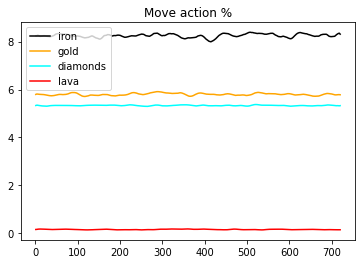

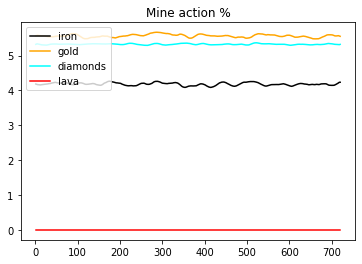

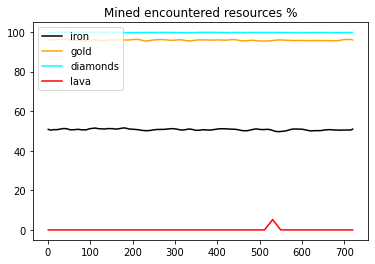

[0:36:24]>[0:23:36] episode 725, avg score 51.28828125, epsilon 0.1
[0:36:39]>[0:23:21] episode 730, avg score 51.278203125, epsilon 0.1
[0:36:54]>[0:23:06] episode 735, avg score 51.27703125, epsilon 0.1
[0:37:09]>[0:22:51] episode 740, avg score 51.2415625, epsilon 0.1
[0:37:25]>[0:22:35] episode 745, avg score 51.253515625, epsilon 0.1
[0:37:40]>[0:22:20] episode 750, avg score 51.24109375, epsilon 0.1
[0:37:55]>[0:22:05] episode 755, avg score 51.24421875, epsilon 0.1
[0:38:10]>[0:21:50] episode 760, avg score 51.25, epsilon 0.1
[0:38:25]>[0:21:35] episode 765, avg score 51.224453125, epsilon 0.1
[0:38:40]>[0:21:20] episode 770, avg score 51.229453125, epsilon 0.1
[0:38:55]>[0:21:05] episode 775, avg score 51.209921875, epsilon 0.1
[0:39:10]>[0:20:50] episode 780, avg score 51.22296875, epsilon 0.1


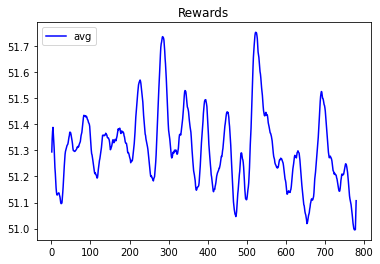

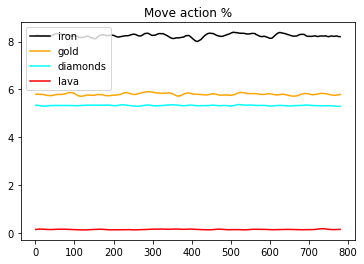

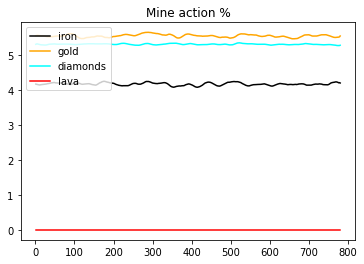

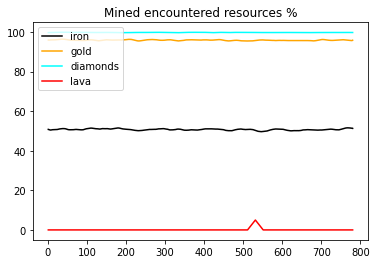

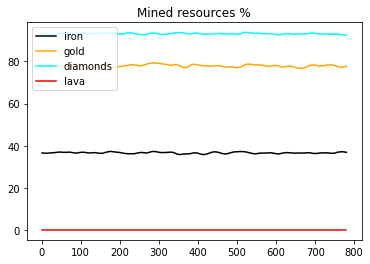

[0:39:27]>[0:20:33] episode 785, avg score 51.229140625, epsilon 0.1
[0:39:42]>[0:20:18] episode 790, avg score 51.231953125, epsilon 0.1
[0:39:57]>[0:20:03] episode 795, avg score 51.21703125, epsilon 0.1
[0:40:12]>[0:19:48] episode 800, avg score 51.1934375, epsilon 0.1
[0:40:28]>[0:19:32] episode 805, avg score 51.21203125, epsilon 0.1
[0:40:42]>[0:19:18] episode 810, avg score 51.223359375, epsilon 0.1
[0:40:58]>[0:19:02] episode 815, avg score 51.2396875, epsilon 0.1
[0:41:13]>[0:18:47] episode 820, avg score 51.23296875, epsilon 0.1
[0:41:28]>[0:18:32] episode 825, avg score 51.238515625, epsilon 0.1
[0:41:44]>[0:18:16] episode 830, avg score 51.22671875, epsilon 0.1
[0:41:59]>[0:18:01] episode 835, avg score 51.206796875, epsilon 0.1
[0:42:14]>[0:17:46] episode 840, avg score 51.206875, epsilon 0.1


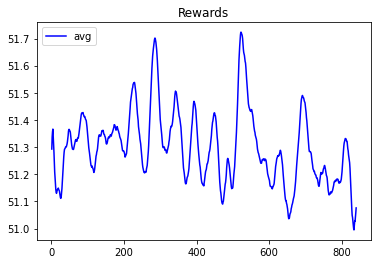

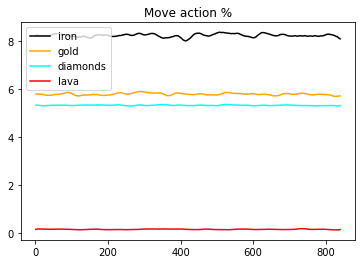

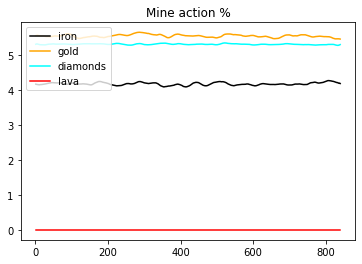

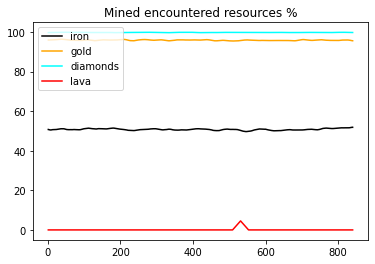

[0:42:31]>[0:17:29] episode 845, avg score 51.211875, epsilon 0.1
[0:42:47]>[0:17:13] episode 850, avg score 51.211015625, epsilon 0.1
[0:43:01]>[0:16:59] episode 855, avg score 51.230703125, epsilon 0.1
[0:43:16]>[0:16:44] episode 860, avg score 51.23234375, epsilon 0.1
[0:43:32]>[0:16:28] episode 865, avg score 51.22328125, epsilon 0.1
[0:43:46]>[0:16:14] episode 870, avg score 51.226328125, epsilon 0.1
[0:44:01]>[0:15:59] episode 875, avg score 51.23546875, epsilon 0.1
[0:44:16]>[0:15:44] episode 880, avg score 51.24625, epsilon 0.1
[0:44:31]>[0:15:29] episode 885, avg score 51.25328125, epsilon 0.1
[0:44:47]>[0:15:13] episode 890, avg score 51.2209375, epsilon 0.1
[0:45:01]>[0:14:59] episode 895, avg score 51.217265625, epsilon 0.1
[0:45:16]>[0:14:44] episode 900, avg score 51.2084375, epsilon 0.1


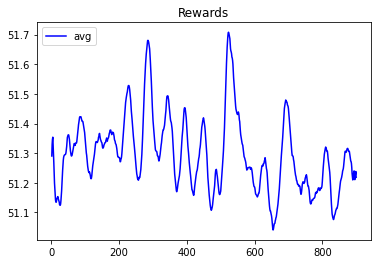

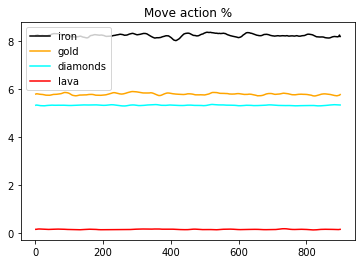

[0:45:34]>[0:14:26] episode 905, avg score 51.204375, epsilon 0.1
[0:45:49]>[0:14:11] episode 910, avg score 51.22171875, epsilon 0.1
[0:46:04]>[0:13:56] episode 915, avg score 51.2109375, epsilon 0.1
[0:46:19]>[0:13:41] episode 920, avg score 51.216640625, epsilon 0.1
[0:46:34]>[0:13:26] episode 925, avg score 51.221953125, epsilon 0.1
[0:46:50]>[0:13:10] episode 930, avg score 51.222734375, epsilon 0.1
[0:47:05]>[0:12:55] episode 935, avg score 51.19921875, epsilon 0.1
[0:47:20]>[0:12:40] episode 940, avg score 51.24890625, epsilon 0.1
[0:47:35]>[0:12:25] episode 945, avg score 51.253671875, epsilon 0.1
[0:47:51]>[0:12:09] episode 950, avg score 51.26984375, epsilon 0.1
[0:48:05]>[0:11:55] episode 955, avg score 51.26953125, epsilon 0.1
[0:48:21]>[0:11:39] episode 960, avg score 51.252109375, epsilon 0.1


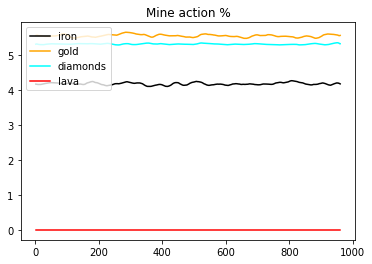

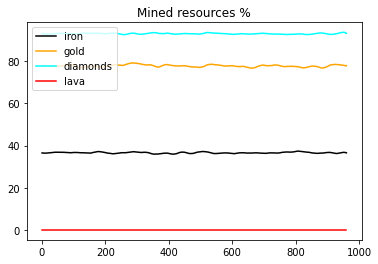

[0:48:38]>[0:11:22] episode 965, avg score 51.27375, epsilon 0.1
[0:48:53]>[0:11:07] episode 970, avg score 51.29265625, epsilon 0.1
[0:49:09]>[0:10:51] episode 975, avg score 51.299765625, epsilon 0.1
[0:49:24]>[0:10:36] episode 980, avg score 51.288828125, epsilon 0.1
[0:49:39]>[0:10:21] episode 985, avg score 51.266015625, epsilon 0.1
[0:49:54]>[0:10:06] episode 990, avg score 51.255546875, epsilon 0.1
[0:50:09]>[0:09:51] episode 995, avg score 51.25109375, epsilon 0.1
[0:50:24]>[0:09:36] episode 1000, avg score 51.25984375, epsilon 0.1
[0:50:39]>[0:09:21] episode 1005, avg score 51.271953125, epsilon 0.1
[0:50:55]>[0:09:05] episode 1010, avg score 51.2546875, epsilon 0.1
[0:51:10]>[0:08:50] episode 1015, avg score 51.24828125, epsilon 0.1
[0:51:25]>[0:08:35] episode 1020, avg score 51.255703125, epsilon 0.1


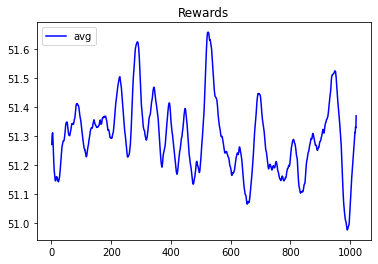

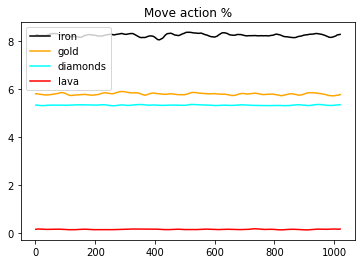

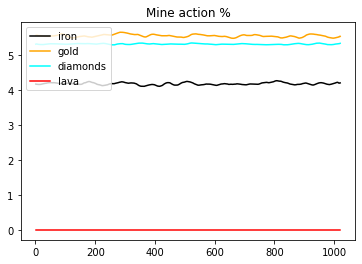

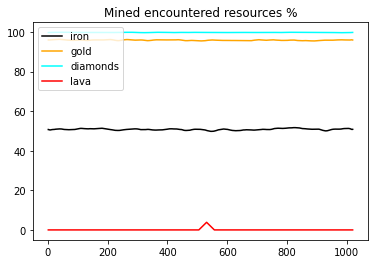

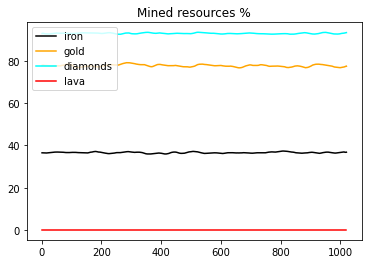

[0:51:42]>[0:08:18] episode 1025, avg score 51.243359375, epsilon 0.1
[0:51:57]>[0:08:03] episode 1030, avg score 51.25390625, epsilon 0.1
[0:52:13]>[0:07:47] episode 1035, avg score 51.291328125, epsilon 0.1
[0:52:28]>[0:07:32] episode 1040, avg score 51.281484375, epsilon 0.1
[0:52:43]>[0:07:17] episode 1045, avg score 51.2646875, epsilon 0.1
[0:52:58]>[0:07:02] episode 1050, avg score 51.2796875, epsilon 0.1
[0:53:13]>[0:06:47] episode 1055, avg score 51.27625, epsilon 0.1
[0:53:29]>[0:06:31] episode 1060, avg score 51.27546875, epsilon 0.1
[0:53:45]>[0:06:15] episode 1065, avg score 51.285546875, epsilon 0.1
[0:54:00]>[0:06:00] episode 1070, avg score 51.280703125, epsilon 0.1
[0:54:15]>[0:05:45] episode 1075, avg score 51.296796875, epsilon 0.1
[0:54:30]>[0:05:30] episode 1080, avg score 51.292109375, epsilon 0.1


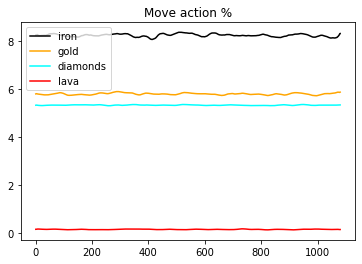

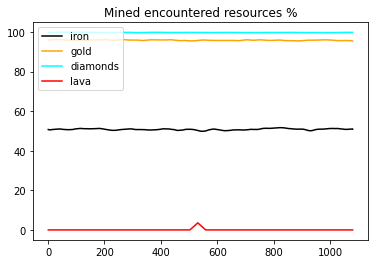

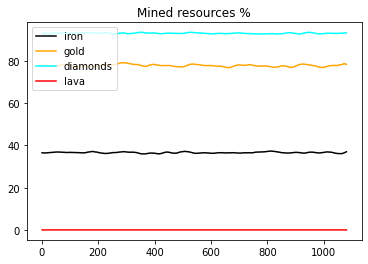

[0:54:47]>[0:05:13] episode 1085, avg score 51.305, epsilon 0.1
[0:55:03]>[0:04:57] episode 1090, avg score 51.287421875, epsilon 0.1
[0:55:18]>[0:04:42] episode 1095, avg score 51.305625, epsilon 0.1
[0:55:33]>[0:04:27] episode 1100, avg score 51.2978125, epsilon 0.1
[0:55:49]>[0:04:11] episode 1105, avg score 51.309296875, epsilon 0.1
[0:56:04]>[0:03:56] episode 1110, avg score 51.287421875, epsilon 0.1
[0:56:19]>[0:03:41] episode 1115, avg score 51.3034375, epsilon 0.1
[0:56:34]>[0:03:26] episode 1120, avg score 51.301640625, epsilon 0.1
[0:56:49]>[0:03:11] episode 1125, avg score 51.30375, epsilon 0.1
[0:57:04]>[0:02:56] episode 1130, avg score 51.301796875, epsilon 0.1
[0:57:20]>[0:02:40] episode 1135, avg score 51.301328125, epsilon 0.1
[0:57:35]>[0:02:25] episode 1140, avg score 51.283203125, epsilon 0.1


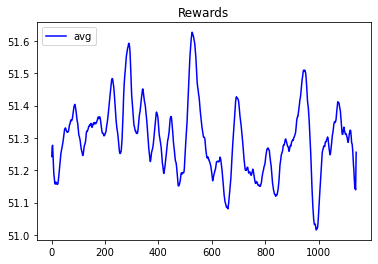

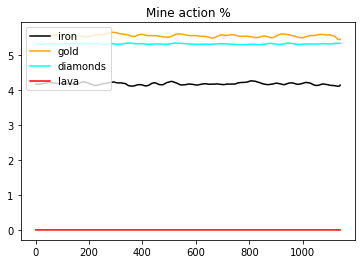

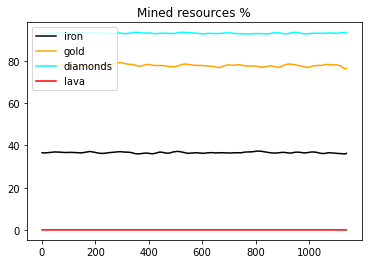

[0:57:53]>[0:02:07] episode 1145, avg score 51.255703125, epsilon 0.1
[0:58:08]>[0:01:52] episode 1150, avg score 51.25109375, epsilon 0.1
[0:58:23]>[0:01:37] episode 1155, avg score 51.23453125, epsilon 0.1
[0:58:38]>[0:01:22] episode 1160, avg score 51.249765625, epsilon 0.1
[0:58:53]>[0:01:07] episode 1165, avg score 51.24375, epsilon 0.1
[0:59:08]>[0:00:52] episode 1170, avg score 51.228359375, epsilon 0.1
[0:59:23]>[0:00:37] episode 1175, avg score 51.236484375, epsilon 0.1
[0:59:38]>[0:00:22] episode 1180, avg score 51.24625, epsilon 0.1
[0:59:53]>[0:00:07] episode 1185, avg score 51.254140625, epsilon 0.1
Run ended
[1:00:02]>[23:59:59] episode 1189, avg score 51.237265625, epsilon 0.1


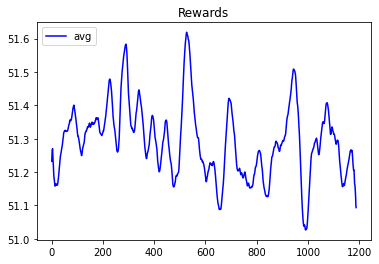

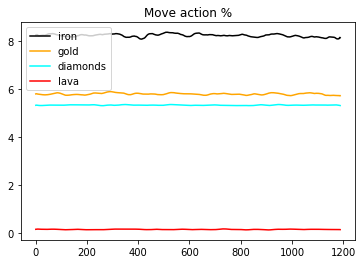

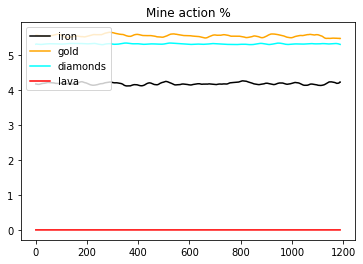

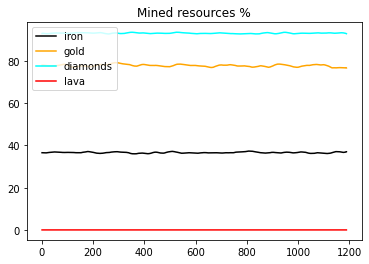

In [ ]:
run_test()